In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
import muon as mu
from matplotlib.pyplot import rc_context
import os
from anndata import AnnData
import matplotlib
import symphonypy as sp
from scipy.stats import gaussian_kde
import decoupler as dc
import pertpy as pt
from scipy import stats
from scipy.stats import mannwhitneyu, kruskal
from sklearn.preprocessing import Binarizer
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy

/home/sina.kanannejad/miniconda3/envs/pertpy-env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [7]:
sc._settings.settings._vector_friendly=True
sc.settings.verbosity = 0
sc.settings.set_figure_params(
    dpi=300,dpi_save = 300,
    facecolor="white",
    frameon=False, fontsize = 8
)
sc.settings.figdir = "/Fig_2/"
sns.set_theme(style="white")

In [4]:
CELLTYPE_COLORS = {
    'Erythroid_Prog': '#E41A1C',  # red
    'Progenitors': '#377EB8',     # blue
    'HSC': '#984EA3',            # changed to purple
    'Erythroid': '#66C2A5',      # changed to mint
    'GMP': '#FF7F00',           # orange
    'B_prog': '#FFFF33',        # yellow
    'B Cell': '#A65628',        # brown
    'T Cells': '#F781BF',       # pink
    'Monocytes': '#E6AB02',     # changed to gold
    'NK Cells': '#A6D854',      # changed to lime
    'ProMono': '#FC8D62',       # coral
    'DCs': '#8DA0CB',           # light blue
    "Cycling" : "green"
}

color_dict_sample_broad = {
    'AML3': '#2ECC71',    # Emerald green
    'AML4': '#E74C3C',    # Bright red
    'AML5': '#C0392B',    # Dark red
    'AML6': '#F39C12',    # Orange
    'AML7': '#2C3E50',    # Navy blue
    'AML8': '#3498DB',    # Bright blue
    'AML9': '#87CEEB',    # Sky blue
    'AML10': '#8B4513',   # Saddle brown
    'AML11': '#9B59B6',   # Purple
    'AML12': '#FF7F50',   # Coral
    'AML13': '#FF1493',   # Deep pink
    'AML14': '#8B008B',   # Dark magenta
    'AML15': '#6B8E23',   # Olive drab
    'AML16': '#556B2F',   # Dark olive green
    'AML17': '#808000',   # Olive
    'AML19': '#698B22',   # Dark olive
    'Healthy': '#D2B48C'  # Tan
}

malignancy_colors = {
    "GMP_AML": "brown",       
    "GMP_Healthy": "teal",
    "Erythroid_Prog_AML": "brown",
    "Erythroid_Prog_Healthy": "teal",
    "Progenitors_AML": "brown",
    "HSC_Healthy": "teal"
}

color_dict_cyto = {'NUP98r': 'brown',
    'GLIS2': 'red',
    'DEK_NUP214': 'blue',
    'MNX1': 'olive',
    'KMT2Ar': 'green',
    'RUNX1_RUNX1T1': 'violet',
    'CBFB_MYH11': 'indigo',
    'Healthy': 'lightgrey',
    'unknown': 'tan'
    }

In [5]:
def plot_boxplot_with_stats(adata, categorical_col, numerical_col, figsize=(8, 6), 
                           palette=None, jitter=True, alpha=0.4, save_path=None, 
                           dpi=300, format='pdf'):
    """
    Create a boxplot with statistical significance markers at the top from AnnData object.
    
    Parameters:
    -----------
    adata : AnnData
        Annotated data object
    categorical_col : str
        Column name for categorical variable
    numerical_col : str
        Column name for numerical variable
    figsize : tuple
        Figure size (width, height)
    palette : str or list
        Color palette for the plot
    jitter : bool
        Whether to add jittered points
    alpha : float
        Transparency for jittered points
    save_path : str, optional
        Path to save the figure (e.g., '/path/to/figure.pdf')
    dpi : int
        Resolution for saved figure (default: 300)
    format : str
        File format for saving (default: 'pdf')
    
    Returns:
    --------
    dict: Statistical test results
    """
    # Clear any existing plots
    plt.clf()
    plt.close('all')
    
    # Create figure
    plt.figure(figsize=figsize)
    
    # Remove seaborn grid style
    sns.set_style("whitegrid")
    
    # Create boxplot
    if jitter:
        ax = sns.boxplot(data=adata.obs, x=categorical_col, y=numerical_col, 
                        palette=palette, showfliers=False)
        sns.stripplot(data=adata.obs, x=categorical_col, y=numerical_col, 
                     color='black', alpha=alpha, size=3)
    else:
        ax = sns.boxplot(data=adata.obs, x=categorical_col, y=numerical_col, 
                        palette=palette)
    
    # Remove all grids explicitly
    ax.grid(False)
    ax.set_axisbelow(False)
    
    # Get unique categories
    categories = adata.obs[categorical_col].unique()
    
    # Initialize variables for statistical test
    stat = None
    pval = None
    
    # Perform statistical test
    if len(categories) >= 2:
        # For 2 categories: Mann-Whitney U test
        if len(categories) == 2:
            cat1_data = adata.obs[adata.obs[categorical_col] == categories[0]][numerical_col]
            cat2_data = adata.obs[adata.obs[categorical_col] == categories[1]][numerical_col]
            
            stat, pval = stats.mannwhitneyu(cat1_data, cat2_data, alternative='two-sided')
            test_name = "Mann-Whitney U test"
            
            # Determine significance symbol
            if pval < 0.001:
                sig_symbol = '***'
            elif pval < 0.01:
                sig_symbol = '**'
            elif pval < 0.05:
                sig_symbol = '*'
            else:
                sig_symbol = 'ns'
            
            # Get data for y-axis positioning
            y_max = max(cat1_data.max(), cat2_data.max())
            y_min = min(cat1_data.min(), cat2_data.min())
            y_range = y_max - y_min
            
            # Add significance bar
            bar_height = y_max + y_range * 0.1
            bar_tips = y_max + y_range * 0.05
            
            # Plot the significance bar
            plt.plot([0, 0, 1, 1], 
                    [bar_tips, bar_height, bar_height, bar_tips], 
                    'k-', linewidth=1)
            
            # Add the significance asterisks
            plt.text(0.5, bar_height + y_range * 0.02, 
                    sig_symbol, 
                    ha='center', va='bottom',
                    fontsize=12)
            
            # Update y-axis limits to show significance bar
            plt.ylim(y_min - y_range * 0.1, bar_height + y_range * 0.15)
            
            # Print statistical test results
            print(f"\n{test_name} results:")
            print(f"p-value: {pval:.2e}")
            print(f"Significance: {sig_symbol}")
            
        else:
            # For more than 2 categories: Kruskal-Wallis H-test
            groups = [group for name, group in adata.obs.groupby(categorical_col)[numerical_col]]
            stat, pval = stats.kruskal(*groups)
            print(f"\nKruskal-Wallis H-test results:")
            print(f"p-value: {pval:.2e}")
    
    # Customize plot
    plt.title(f'{numerical_col} by {categorical_col}')
    
    # Remove any remaining grid elements
    plt.grid(False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    # Add number of samples in each category (commented out as in original)
    #n_samples = adata.obs[categorical_col].value_counts()
    #xlabel_text = [f'{cat}\n(n={n_samples[cat]})' for cat in categories]
    #plt.gca().set_xticklabels(xlabel_text)
    
    plt.tight_layout()
    
    # Save figure if path is provided
    if save_path:
        plt.savefig(save_path, format=format, dpi=dpi, bbox_inches='tight')
        print(f"Figure saved to: {save_path}")
    
    plt.show()
    
    # Return statistical test results
    return {'statistic': stat, 'pvalue': pval}



def plot_stacked_barplot(
    adata, 
    groupby_columns, 
    color_dict, 
    figsize=(10, 10), 
    group_order=None, 
    meta_col=None, 
    meta_color_dict=None,
    save_path=None, 
    dpi=300, 
    format='pdf'
):
    """
    Plots a horizontal stacked barplot with optional metadata color bar on the left.

    Parameters:
    -----------
    adata : AnnData object
        Annotated data matrix.
    groupby_columns : list
        Two strings specifying the obs columns to group by [group, count].
    color_dict : dict
        Dictionary mapping categories in the second group (count) to colors.
    figsize : tuple
        Figure size (default: (10, 10)).
    group_order : list, optional
        Order of groups on y-axis.
    meta_col : str, optional
        Column in adata.obs for side annotation (e.g., "cyto").
    meta_color_dict : dict, optional
        Dictionary mapping meta_col values to colors.
    save_path : str, optional
        Path to save the figure.
    dpi : int
        Resolution for saved figure (default: 300).
    format : str
        File format (default: 'pdf').

    Returns:
    --------
    fig, ax : matplotlib figure and axes objects
    """

    group, count = groupby_columns
    
    # Create a DataFrame with group counts
    df = adata.obs.groupby(groupby_columns).size().reset_index(name='count')
    
    # Normalize within each group
    df['percent'] = df.groupby(group)['count'].apply(lambda x: 100 * x / x.sum()).reset_index(drop=True)
    
    # Pivot for plotting
    pivot_df = df.pivot(index=group, columns=count, values='percent').fillna(0)
    
    # Reorder y-axis
    if group_order is not None:
        valid_groups = [g for g in group_order if g in pivot_df.index]
        pivot_df = pivot_df.reindex(valid_groups)
    
    # Validate color_dict
    missing_colors = [c for c in pivot_df.columns if c not in color_dict]
    if missing_colors:
        raise ValueError(f"Missing colors for: {missing_colors}")
    colors = [color_dict[c] for c in pivot_df.columns]

    # Prepare metadata mapping if provided
    meta_colors = None
    if meta_col is not None:
        meta_vals = adata.obs[[group, meta_col]].drop_duplicates().set_index(group)
        if meta_color_dict is None:
            raise ValueError("meta_color_dict must be provided when using meta_col")
        meta_colors = meta_vals.loc[pivot_df.index, meta_col].map(meta_color_dict)

    # Create figure
    fig, ax = plt.subplots(figsize=figsize)

    # Plot stacked horizontal bars
    pivot_df.plot(kind='barh', stacked=True, color=colors, width=0.7, ax=ax)

    # If meta_col given, add a color bar on the left
    if meta_colors is not None:
        for y, color in enumerate(meta_colors):
            ax.barh(y, -3, color=color, edgecolor="none")  # negative width to draw on left
        ax.set_xlim(left=-3)  # expand axis so color bar is visible

        # Add legend for meta_col
        handles = [plt.Rectangle((0,0),1,1, color=c) for c in meta_color_dict.values()]
        ax.legend(handles, meta_color_dict.keys(), title=meta_col, bbox_to_anchor=(1.05, 1))

    # Customize
    plt.xlabel("Percentage")
    plt.ylabel(group)
    plt.title(f"Distribution of {count} by {group}")
    plt.tight_layout()

    # Save figure if path is provided
    if save_path:
        plt.savefig(save_path, format=format, dpi=dpi, bbox_inches='tight')
        print(f"Figure saved to: {save_path}")

    plt.show()
    return fig, ax



def plot_fusion_counts(adata, fusion_col='fus_new', status_col='malignancy_status', 
                      color_col='sample_major', figsize=(12, 6), save_path=None, 
                      dpi=300, format='pdf'):
    """
    Stacked bar plot showing fusion counts colored by sample_major
    
    Parameters:
    -----------
    adata : AnnData
        Annotated data object
    fusion_col : str
        Column name for fusion information
    status_col : str
        Column name for malignancy status
    color_col : str
        Column name for sample information
    figsize : tuple
        Figure size (width, height)
    save_path : str, optional
        Path to save the figure (e.g., '/path/to/figure.pdf')
    dpi : int
        Resolution for saved figure (default: 300)
    format : str
        File format for saving (default: 'pdf')
    """
    # Count fusions
    fusion_counts = adata.obs[fusion_col].str.count(',') + 1
    fusion_counts[adata.obs[fusion_col].isna()] = 0
    
    # Create DataFrame with fusion counts and sample information
    df = pd.DataFrame({
        'status': adata.obs[status_col],
        'sample': adata.obs[color_col],
        'has_fusion': fusion_counts > 0
    })
    
    # Count fusions by status and sample
    fusion_counts = df[df['has_fusion']].groupby(['status', 'sample']).size().reset_index()
    fusion_counts.columns = ['status', 'sample', 'count']
    
    # Pivot the data for stacking
    fusion_counts_pivot = fusion_counts.pivot(index='status', columns='sample', values='count')
    fusion_counts_pivot = fusion_counts_pivot.fillna(0)
    
    # Create plot
    fig, ax = plt.subplots(figsize=figsize)
    
    # Create stacked bar plot
    fusion_counts_pivot.plot(kind='bar', stacked=True, 
                            color=color_dict_sample_broad.values(), ax=ax)
    
    # Remove grid
    ax.grid(False)
    ax.set_axisbelow(False)
    
    # Remove top and right spines for cleaner look
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    # Customize plot
    plt.title('Number of Cells with Fusions by Malignancy Status')
    plt.xlabel('Status')
    plt.ylabel('Number of Cells with Fusions')
    plt.legend(title='Sample', bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Rotate x-axis labels for better readability
    plt.xticks(rotation=45, ha='right')
    
    plt.tight_layout()
    
    # Save figure if path is provided
    if save_path:
        plt.savefig(save_path, format=format, dpi=dpi, bbox_inches='tight')
        print(f"Figure saved to: {save_path}")
    
    plt.show()
    
    # Print total counts
    print("\nTotal cells with fusions by status:")
    print(fusion_counts.groupby('status')['count'].sum())

# Usage examples:
"""
# Just display (no saving)
plot_fusion_counts(adata)

# Save as PDF
plot_fusion_counts(adata, save_path="/path/to/fusion_counts.pdf")

# Save as PNG with high resolution
plot_fusion_counts(adata, save_path="/path/to/fusion_counts.png", 
                  format='png', dpi=600)

# Customize and save
plot_fusion_counts(adata, figsize=(15, 8), 
                  save_path="/path/to/fusion_counts_large.pdf")
"""



def create_ECF_df(adata,group):

    adata = adata[adata.obs["cluster_annotation"].isin(group)].copy()
    group_name = adata.obs["cluster_annotation"].iloc[0]
    
    #put the right layer 
    adata.X = adata.layers["raw_counts"].copy()
    print(f"Max raw counts: {np.max(adata.X)}")

    # Extract the counts matrix
    M = adata.X
    
    # Binarize the matrix
    binarizer = Binarizer(threshold=0)
    bin_M = binarizer.fit_transform(M)
    print(f"Max_after_bin: {np.max(bin_M)}")

    # Calculate ECF
    ECF = np.sum(bin_M, axis=0) / bin_M.shape[0] 
    ECF = np.array(ECF).flatten()

    #normalize data here
    adata.X = adata.layers["raw_counts"].copy()
    mu.prot.pp.clr(adata, axis=1)
    #sc.pp.normalize_total(adata)
    #sc.pp.log1p(adata)
    M_norm = adata.X.copy()
    print(f"Max_after_normalization:{np.max(M_norm)}")
    
    # Calculate total expression sums
    exp_sums = np.sum(M_norm, axis=0)
    exp_sums = np.array(exp_sums).flatten()

    #non_zero _genes
    non_zero = np.count_nonzero(bin_M.toarray(), axis = 0)


    
    # Calculate average expression for all
    avr_exp_all = exp_sums / M.shape[0]  # Average expression all
    avr_exp_NZ = exp_sums / non_zero  # Average expression among non zero cells
    


    # Get variable names
    var_names = adata.var_names
    
    # Multiply ECF by average expression
    ECF_times_avr_exp = ECF * avr_exp_all
    ECF_times_avr_exp_nz = ECF * avr_exp_NZ


    # Create a DataFrame with variable names and the computed values
    result_df = pd.DataFrame({
        'Gene': var_names,
        'ECF': ECF,
        'Average_Expression': avr_exp_all,
        'Average_Expression_non_zero': avr_exp_NZ,
        'ECF*Average_Expression': ECF_times_avr_exp,
        'ECF*Average_Expression_non_zero': ECF_times_avr_exp_nz

    })

    result_df['Average_Expression_non_zero'].fillna(0, inplace=True)

    
    result_df.columns = ['Gene'] + [f"{group_name}_{col}" for col in result_df.columns[1:]]


    sorted_df = result_df.sort_values(by=result_df.columns[4], ascending=False)

    return sorted_df    


def process_cluster(
    cluster, 
    joint_obj, 
    df_reference, 
    group_name="HSC", 
    n_top_adts=None,
    save_path=None,
    dpi=300,
    format='pdf'
):
    """
    Process and visualize cluster data with ordered markers shown on both sides

    Args:
        cluster: Cluster identifier
        joint_obj: Joint object containing cluster data
        df_reference: Reference dataframe (previously df_HSC)
        group_name: Name of the reference group (default "HSC")
        n_top_adts: Number of top ADTs to show for each group (if None, show all)
        save_path: str, optional - Path to save the figure (e.g., '/path/to/figure.pdf')
        dpi: int - Resolution for saved figure (default: 300)
        format: str - File format for saving (default: 'pdf')
    """

    # Create ECF dataframe for the cluster
    df = create_ECF_df(joint_obj, group=[cluster])
    df = df[~df['Gene'].str.startswith('Isotype', na=False)]

    # Merge with reference dataframe
    df_merged = pd.merge(df, df_reference, on="Gene", how="inner")

    # Rename the reference ECF column if it's different
    ref_ecf_col = f"{group_name}_ECF"
    if "HSC_ECF" in df_merged.columns and group_name != "HSC":
        df_merged = df_merged.rename(columns={"HSC_ECF": ref_ecf_col})

    # Annotate genes based on conditions
    def annotate_gene(row):
        if row[ref_ecf_col] > 0.5:
            return f"{group_name}_high"
        elif (row[f"{cluster}_ECF"] > 0.4) and (row[ref_ecf_col] < 0.5):
            return "cluster_optimum"
        else:
            return "not_relevant"

    expr_col = f"{cluster}_Average_Expression"
    df_merged["Annotation"] = df_merged.apply(annotate_gene, axis=1)

    # Filter and sort both categories
    cluster_high_df = df_merged[df_merged["Annotation"] == "cluster_optimum"].sort_values(
        f"{cluster}_ECF", ascending=True
    )
    ref_high_df = df_merged[df_merged["Annotation"] == f"{group_name}_high"].sort_values(
        ref_ecf_col, ascending=True
    )

    # Select top ADTs if requested
    if n_top_adts is not None:
        cluster_high_df = cluster_high_df.tail(n_top_adts)
        ref_high_df = ref_high_df.tail(n_top_adts)

    # Combine the ordered genes
    ordered_genes = pd.concat([ref_high_df, cluster_high_df])

    # Create figure
    total_genes = len(cluster_high_df) + len(ref_high_df)
    fig_height = max(6, total_genes * 0.3)
    fig, ax = plt.subplots(figsize=(15, fig_height))

    if expr_col in df_merged.columns:
        # Create normalizers for color mapping
        norm = mcolors.Normalize(
            vmin=ordered_genes[expr_col].min(),
            vmax=ordered_genes[expr_col].max()
        )

        # Plot both reference and cluster bars for ordered genes
        bars_ref = ax.barh(
            ordered_genes["Gene"],
            -ordered_genes[ref_ecf_col],  # Negative for left side
            color=cm.Reds(norm(ordered_genes[expr_col])),
            label=group_name
        )

        bars_cluster = ax.barh(
            ordered_genes["Gene"],
            ordered_genes[f"{cluster}_ECF"],  # Positive for right side
            color=cm.viridis(norm(ordered_genes[expr_col])),
            label=cluster
        )

        # Add reference lines
        ax.axvline(x=0, color='black', linestyle='-', alpha=0.5)
        ax.axvline(x=0.5, color='red', linestyle='--', alpha=0.5)
        ax.axvline(x=0.9, color='red', linestyle='--', alpha=0.5)
        ax.axvline(x=-0.5, color='red', linestyle='--', alpha=0.5)
        ax.axvline(x=-0.9, color='red', linestyle='--', alpha=0.5)

        # Labels and title
        ax.set_xlabel("ECF Score", fontweight="bold")
        ax.set_ylabel("Gene", fontweight="bold")
        ax.set_title(
            f"{group_name} High (n={len(ref_high_df)}) vs {cluster} High (n={len(cluster_high_df)})",
            fontweight="bold"
        )

        # Adjust x-axis labels
        ax.set_xticks([-1, -0.5, 0, 0.5, 1])
        ax.set_xticklabels(['1', '0.5', '0', '0.5', '1'])

        # Add colorbars
        sm_ref = cm.ScalarMappable(cmap=cm.Reds, norm=norm)
        sm_cluster = cm.ScalarMappable(cmap=cm.viridis, norm=norm)

        cbar_ref = fig.colorbar(sm_ref, ax=ax, location='left', pad=0.1)
        cbar_cluster = fig.colorbar(sm_cluster, ax=ax, location='right', pad=0.1)

        cbar_ref.set_label('Expression Level', rotation=270, labelpad=15, fontweight="bold")
        cbar_cluster.set_label('Expression Level', rotation=270, labelpad=15, fontweight="bold")

        # Add legend
        #ax.legend(loc='upper right')

        # Print summary
        print(f"Number of {cluster} high markers: {len(cluster_high_df)}")
        print(f"Number of {group_name} high markers: {len(ref_high_df)}")

        plt.tight_layout()
        
        # Save figure if path is provided
        if save_path:
            plt.savefig(save_path, format=format, dpi=dpi, bbox_inches='tight')
            print(f"Figure saved to: {save_path}")
        
        plt.show()

        # Return the dataframes
        return ordered_genes, cluster_high_df, ref_high_df

    else:
        print(f"Error: '{expr_col}' column not found in the dataframe.")
        print(f"Available columns: {df_merged.columns.tolist()}")
        return None, None, None


def count_marker_combinations_heatmap(
    adata,
    gene_list,
    groupby,
    layer=None,
    threshold=0,
    normalize=False,
    show_heatmap=True,
    figsize=(10, 6),
    cmap="viridis",
    return_df=False,
    save_path=None,
    show_combinations=True,
    show_any_all=True,
):
    """
    Count number of positive cells for all individual genes and (optional) their combinations per group.

    Parameters
    ----------
    adata : AnnData
    gene_list : list of str
        List of gene names.
    groupby : str
        Column in adata.obs to group cells.
    layer : str or None
        Expression layer to use. If None, use adata.X.
    threshold : float
        Threshold above which a gene is considered expressed.
    normalize : bool
        If True, report percentages instead of counts.
    show_heatmap : bool
        If True, show heatmap of results.
    figsize : tuple
        Figure size for the heatmap.
    cmap : str
        Colormap for heatmap.
    return_df : bool
        If True, return the result DataFrame.
    save_path : str or None
        If given, save heatmap to this path.
    show_combinations : bool
        If True, compute pairwise (and larger) marker combinations.
    show_any_all : bool
        If True, include "Any+" and "All+" categories.

    Returns
    -------
    pd.DataFrame (optional)
        DataFrame with counts or percentages.
    """

    # Validate
    missing = [g for g in gene_list if g not in adata.var_names]
    if missing:
        raise ValueError(f"Missing genes in adata.var_names: {missing}")
    if groupby not in adata.obs.columns:
        raise ValueError(f"{groupby} is not a column in adata.obs")

    # Get expression matrix
    X = adata.X if layer is None else adata.layers[layer]
    if scipy.sparse.issparse(X):
        X = X.toarray()

    gene_idx = [adata.var_names.get_loc(g) for g in gene_list]
    gene_expr = X[:, gene_idx]
    binary_expr = (gene_expr > threshold).astype(int)

    group_labels = adata.obs[groupby].astype(str)
    unique_groups = sorted(group_labels.unique())
    group_mask_dict = {grp: (group_labels == grp).values for grp in unique_groups}

    # Prepare conditions
    conditions = []

    # Individual markers
    for i, g in enumerate(gene_list):
        mask = binary_expr[:, i]
        conditions.append((g, mask))

    # Any+ / All+
    if show_any_all:
        any_pos = (binary_expr.sum(axis=1) >= 1).astype(int)
        conditions.append(("Any+", any_pos))
        if len(gene_list) > 1:
            all_pos = (binary_expr.sum(axis=1) == len(gene_list)).astype(int)
            conditions.append(("All+", all_pos))

    # Combinations
    if show_combinations:
        for r in range(2, len(gene_list) + 1):
            for combo in itertools.combinations(range(len(gene_list)), r):
                genes = [gene_list[i] for i in combo]
                combo_name = " & ".join(genes)
                combo_mask = np.all(binary_expr[:, combo], axis=1).astype(int)
                conditions.append((combo_name, combo_mask))

    # Build result df
    result = pd.DataFrame(index=unique_groups)
    for name, mask in conditions:
        values = []
        for group in unique_groups:
            gmask = group_mask_dict[group]
            count = mask[gmask].sum()
            total = gmask.sum()
            values.append((count / total * 100) if normalize else count)
        result[name] = values

    # Plot
    if show_heatmap and not result.empty:
        plt.figure(figsize=figsize)
        sns.heatmap(
            result,
            annot=True,
            fmt=".1f" if normalize else ".0f",
            cmap=cmap
        )
        plt.title(f"Marker Positivity by {groupby}" + (" (%)" if normalize else " (count)"))
        plt.xlabel("Marker condition")
        plt.ylabel(groupby)
        plt.xticks(rotation=45, ha="right")
        plt.tight_layout()
        if save_path:
            plt.savefig(save_path, dpi=300)
        plt.show()

    if return_df:
        return result



def add_gene_threshold_obs(adata, gene, layer, threshold):
    
    # Find gene index
    gene_idx = np.where(adata.var_names == gene)[0][0]
    
    # Extract expression for that gene in that layer
    expr = adata.layers[layer][:, gene_idx]
    
    # Convert sparse matrix if needed
    if not isinstance(expr, np.ndarray):
        expr = expr.toarray().ravel()
    
    # Create binary labels
    labels = np.where(expr > threshold, f"{gene}_pos", f"{gene}_neg")
    
    # Add to .obs
    adata.obs[f"{gene}_status"] = labels
    
    return adata    

In [6]:
AML_all = mu.read("/pAML_main.h5mu")

#adding malignancy data
combined_metadata = pd.read_csv("/meta_annotation.csv", index_col = 0)
malig_meta = pd.read_csv("/all_samples_malignancy_scores.csv", index_col = 0)

AML_all["rna"].obs["mapped_healthy"] = combined_metadata["annotation"]
AML_all["rna"].obs["malignancy_score"] = malig_meta["malignancy_score"]
AML_all["rna"].obs["malignancy_status"] = malig_meta["malignancy_status"]
AML_all["rna"].obs["mapped_healthy"] = combined_metadata["annotation"]

AML_all["rna"].obs["malignancy_status"] = AML_all["rna"].obs["malignancy_status"].fillna("healthy")
AML_all["rna"].obs["malignancy_status"].unique()

array(['normal', 'malignant', 'healthy'], dtype=object)

In [7]:
AML_all["rna"][~AML_all["rna"].obs["sample"].isin(["HD1","HD2","PBM","CB1","CB2"])].obs["malignancy_status"].value_counts()

malignancy_status
malignant    163251
normal        37013
healthy       15673
Name: count, dtype: int64

In [ ]:
plot_boxplot_with_stats(
    AML_all["rna"][~AML_all["rna"].obs["malignancy_status"].isin(["Post", "healthy"])], 
    categorical_col='malignancy_status', 
    numerical_col='Blast_score',
    palette={'malignant': 'darkred', 'normal': 'lightblue'},
    save_path = "/Fig_1/blast_score_boxplot.pdf",
    jitter=False
)

In [10]:
fus_meta = pd.read_csv("/fusion_meta.csv", index_col = 0)
AML_all["rna"].obs["fusion"] = fus_meta["fusion_name"]
AML_all["rna"].obs["fusion_id"] = fus_meta["fusion_id"]

In [11]:
def fus_cleaner(fusion):
    if fusion in ["CBFB--MYH11"]:
        return "CBFB-MYH11"
    if fusion in ["KMT2A--AFDN"]:
        return "KMT2A-AFDN"
    if fusion in ["KMT2A--MLLT10"]:
        return "KMT2A-MLLT10"
    if fusion in ["KMT2A--MLLT3"]:
        return "KMT2A-MLLT3"
    if fusion in ["RUNX1--RUNX1T1"]:
        return "RUNX1-RUNX1T1"
    if fusion in ["DEK--NUP214"]:
        return "DEK-NUP214"    
    if fusion in ["NUP98--NSD1"]:
        return "NUP98-NSD1"
    if fusion in ["CBFA2T3--GLIS2"]:
        return "CBFA2T3-GLIS2"
    else :
        return None        

AML_all["rna"].obs["fus_new"] = AML_all["rna"].obs["fusion"].map(fus_cleaner)

In [12]:
AML_all["rna"].obs["malignancy_status"].unique()

array(['normal', 'malignant', 'healthy'], dtype=object)

In [20]:
def add_malignancy_score(adata, sample_type_col='type', leiden_col='leiden_uninteg'):
    """
    Calculate malignancy scores for each leiden cluster
    """
    df = adata.obs[[sample_type_col, leiden_col]].copy()
    malignancy_scores = (
        df.groupby(leiden_col)[sample_type_col]
        .apply(lambda x: (x == 'Tumor').sum() / len(x))
    )
    return malignancy_scores

In [21]:
malignancy_scores= add_malignancy_score(AML_all["rna"], leiden_col = "leiden_res2")
AML_all["rna"].obs['occupancy_score_res2'] = AML_all["rna"].obs["leiden_res2"].map(malignancy_scores).astype(float)

In [22]:
def is_malig (occupancy_score_res2):
    if occupancy_score_res2  == 1:
        return "Malignant"
    else:
        return "Normal"
AML_all["rna"].obs["malignant_normal_occupancy"] = AML_all["rna"].obs["occupancy_score_res2"].map(is_malig)

In [ ]:
plot_fusion_counts(AML_all["rna"][~AML_all["rna"].obs["malignancy_status"].isin(["healthy"])],
                   fusion_col='fus_new', status_col='malignancy_status', 
                      color_col='sample_major', figsize=(4, 5),
                   save_path="/Fig_1/fusion_counts_large.pdf")

In [24]:
AML_all["rna"].obs["mapped_healthy"].value_counts()

mapped_healthy
Progenitors       66059
GMP               37079
Monocytes         35675
Erythroid_Prog    32329
ProMono           16967
T Cells           16155
NK Cells          12679
HSC               10858
B Cell             9753
Cycling            7871
B_prog             5850
Erythroid          5477
DCs                3065
Name: count, dtype: int64

In [14]:
sc.tl.leiden(AML_all["rna"], resolution = 2, key_added = "leiden_res2")
AML_all["rna"].obs["leiden_res2"].to_csv("/home/sina.kanannejad/An_scriptnew/Malignant_normal/leiden-all.csv")

In [25]:
def add_malignancy_score(adata, sample_type_col='type', leiden_col='leiden_uninteg'):
    """
    Calculate malignancy scores for each leiden cluster
    """
    df = adata.obs[[sample_type_col, leiden_col]].copy()
    malignancy_scores = (
        df.groupby(leiden_col)[sample_type_col]
        .apply(lambda x: (x == 'Tumor').sum() / len(x))
    )
    return malignancy_scores

In [74]:
malignancy_scores= add_malignancy_score(AML_all["rna"], leiden_col = "leiden_res2")
AML_all["rna"].obs['occupancy_score_res2'] = AML_all["rna"].obs["leiden_res2"].map(malignancy_scores).astype(float)

In [26]:
def is_malig (occupancy_score_res2):
    if occupancy_score_res2  == 1:
        return "Malignant"
    else:
        return "Normal"
AML_all["rna"].obs["malignant_normal_occupancy"] = AML_all["rna"].obs["occupancy_score_res2"].map(is_malig)

In [ ]:
plot_fusion_counts(AML_all["rna"][~AML_all["rna"].obs["malignancy_status"].isin(["healthy"])],  fusion_col='fus_new', status_col='malignant_normal_occupancy', 
                      color_col='sample_major', figsize=(4, 5),
                  save_path="/Fig_1/fusion_counts_OCCUPANCY.pdf")

In [87]:
AML_all["rna"].obs["malignancy_status"] = AML_all["rna"].obs["malignancy_status"].fillna("Healthy_samples")

In [16]:
malignancy_colors = {
    "malignant": "brown",      
    "normal": "teal",          
    "healthy": "grey"
}


In [15]:
AML_all["rna"].obs["malignancy_status"].unique()

array(['normal', 'malignant', 'healthy'], dtype=object)

/home/sina.kanannejad/miniconda3/envs/pertpy-env/lib/python3.11/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/sina.kanannejad/miniconda3/envs/pertpy-env/lib/python3.11/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


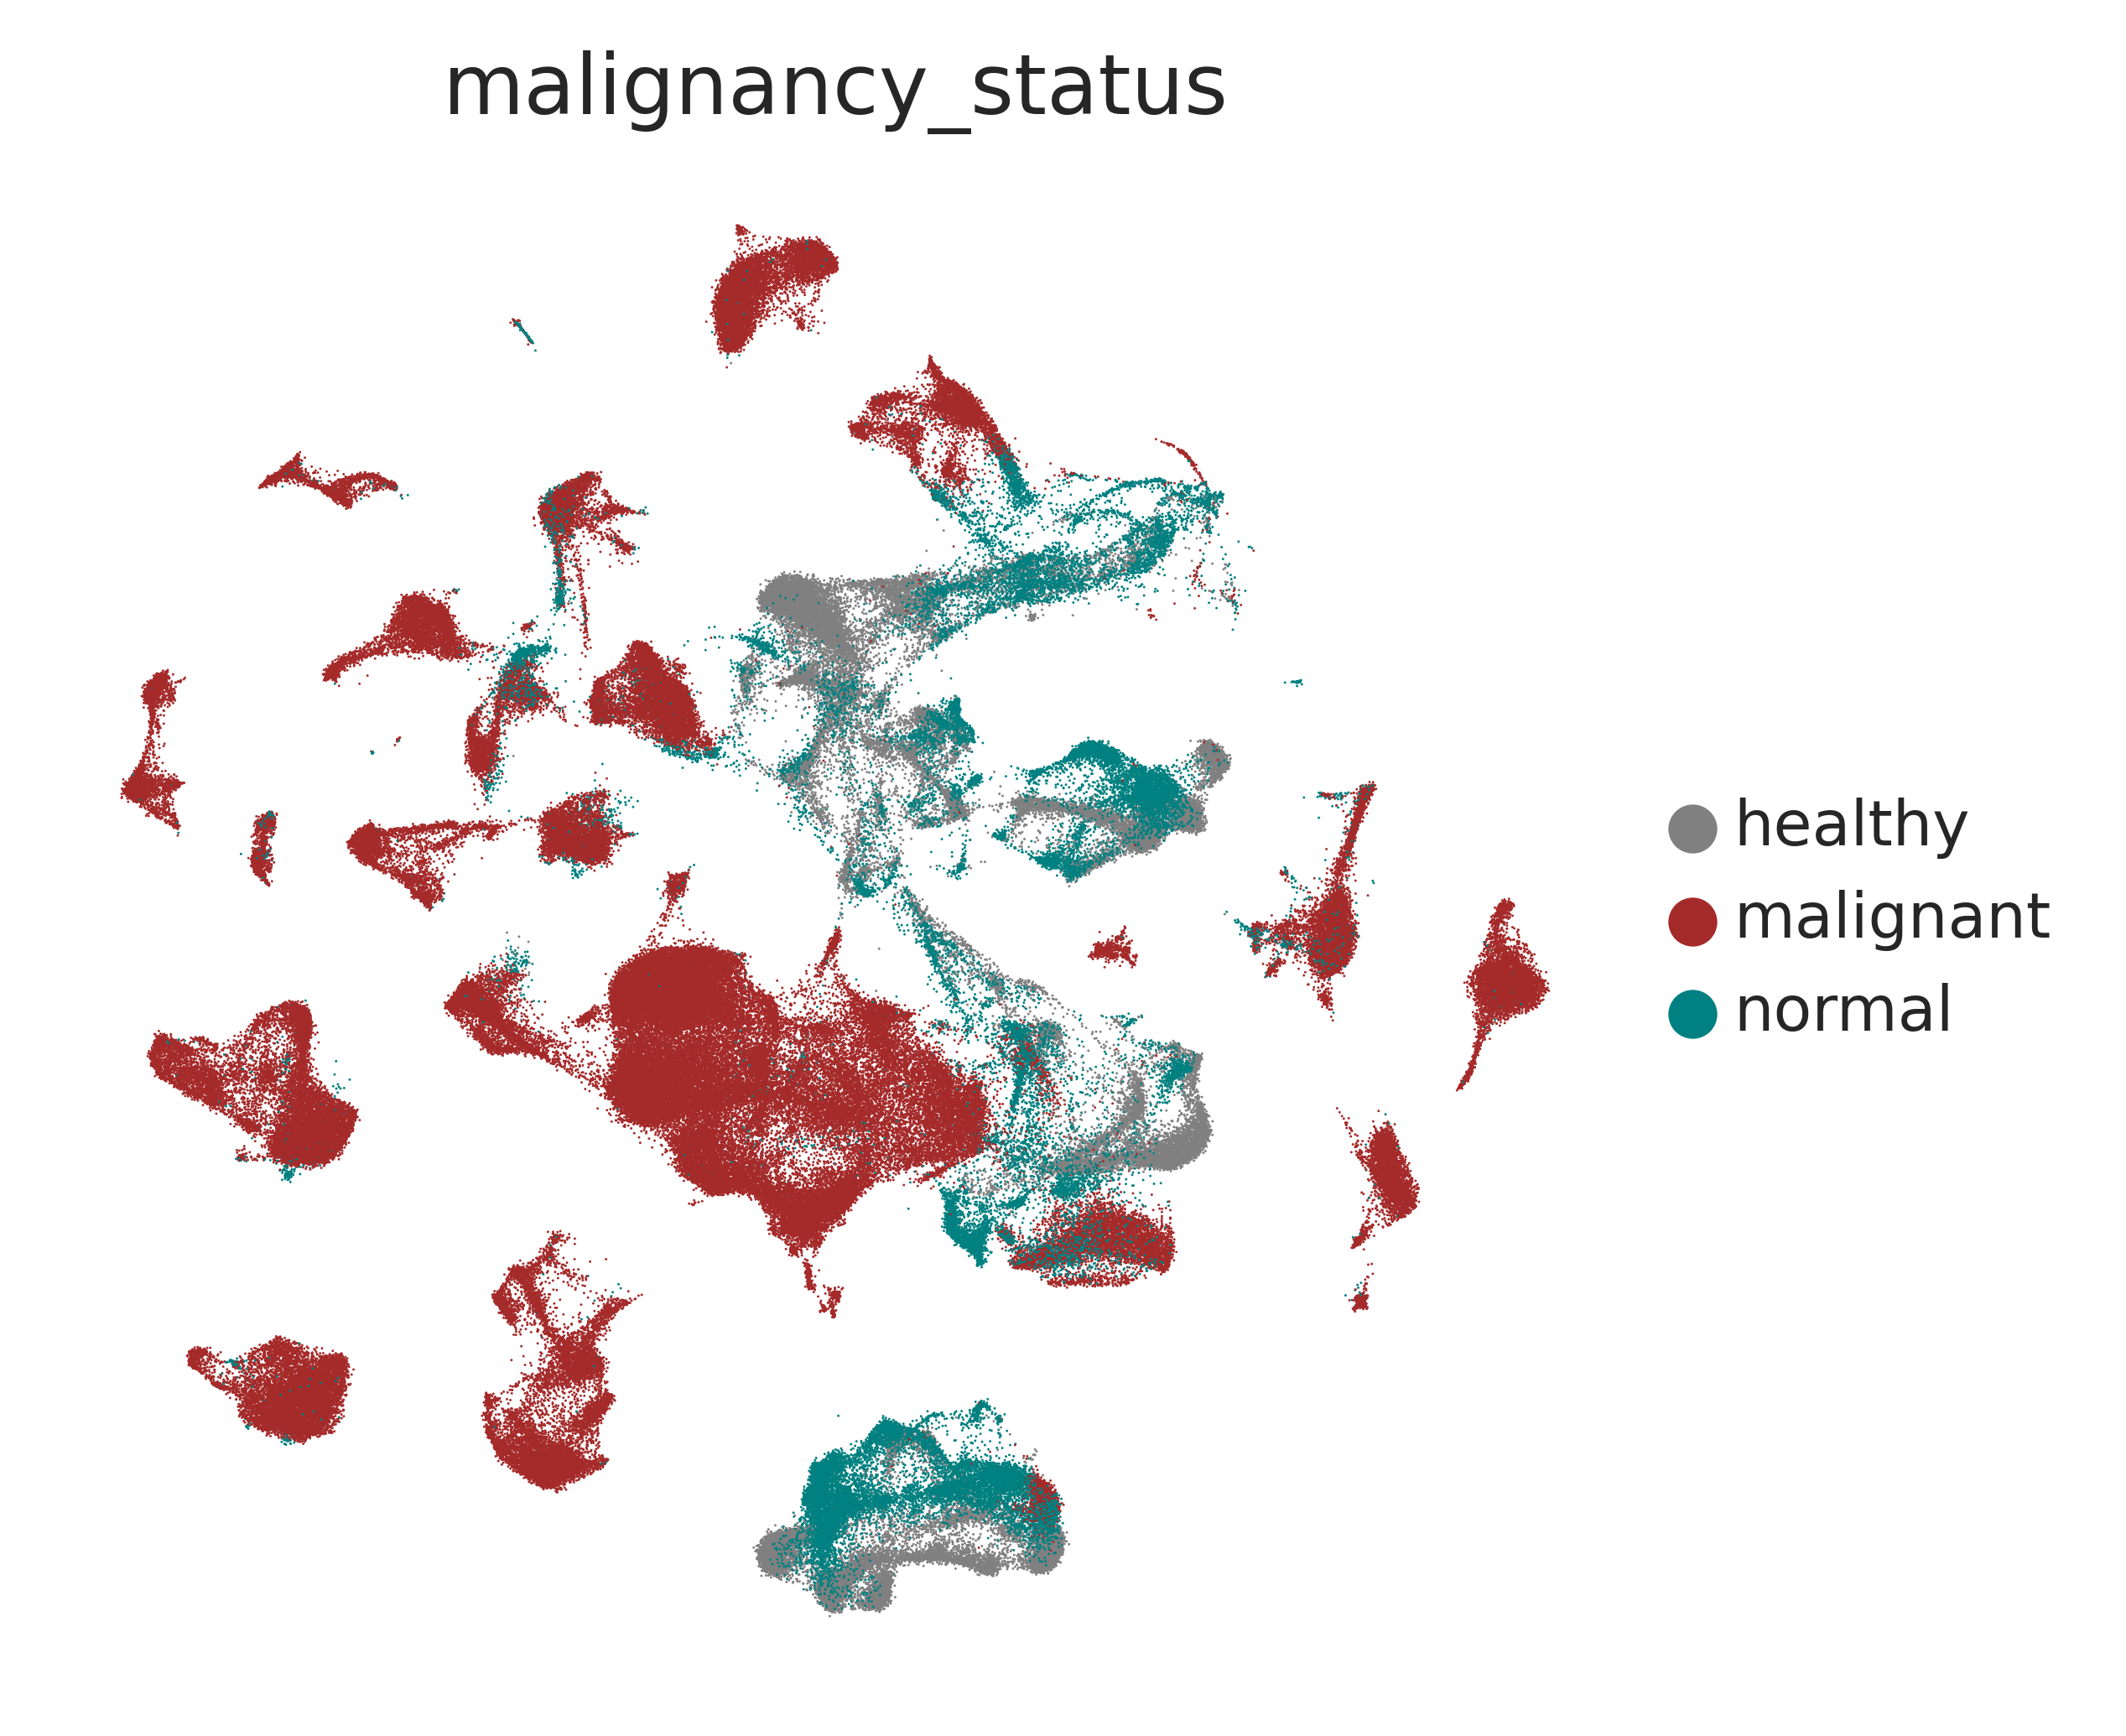

In [17]:
with rc_context({'figure.figsize': (4, 4)}):
    sc.pl.embedding(
    AML_all["rna"][~AML_all["rna"].obs["state"].isin(["post"])],
    color=["malignancy_status"],palette = malignancy_colors,save = "Malignant_normal.pdf",
    basis="X_umap",
     legend_fontsize = 9,legend_fontweight = "large", legend_fontoutline = 7, ncols = 1,
        vmin = "p10", vmax = "p99", color_map = "RdGy_r"
    )

In [18]:
AML_malig = AML_all[(AML_all["rna"].obs["malignancy_status"].isin(["malignant"])) & 
                    (~AML_all["rna"].obs["mapped_healthy"].isin(["NK Cells", "B Cell", "T Cells"]))].copy()
AML_malig

MuData object with n_obs × n_vars = 161374 × 36682
  2 modalities
    rna:	161374 x 36601
      obs:	'n_genes', 'n_counts', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'sample', 'type', 'outlier', 'annotation', 'Cytogenetics', 'state', 'state_major', 'sample_major', 'immu_phe', 'EPPERT_CE_HSC_LSC', 'EPPERT_LSC_R', 'EPPERT_HSC_R', 'GAL_LEUKEMIC_STEM_CELL_UP', 'GENTLES_LEUKEMIC_STEM_CELL_UP', 'LSC104_Ng2016_UP', 'LSPC_Quiescent', 'LSPC_Primed_Top100', 'Bulk_LSC_score', 'LSC104_Ng2016_DOWN', 'MLL_LSC_Somervaille2009_UP', 'MLL_LSC_Somervaille2009_DOWN', 'LSPC_Cycle_Top100', 'GMP_like_Top100', 'ProMono_like_Top100', 'Mono_like_Top100', 'cDC_like_Top100', 'GENTLES_LEUKEMIC_STEM_CELL_DN', 'GAL_LEUKEMIC_STEM_CELL_DN', 'S_score', 'G2M_score', 'Blast_score', 'Blast_extended', 'mapped_healthy', 'malignancy_score', 'malignancy_status'
      var:	'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
      uns:	'Cytogenetics_colors', 'annotation_colors', 'hvg', 'log1p', 'neighbors', 'pca', 'sample_colors', 'sample_major_colors', 'state_colors', 'umap'
      obsm:	'X_pca', 'X_umap', 'aucell_estimate', 'uninteg_UMAP'
      varm:	'PCs'
      layers:	'lognorm_counts', 'raw_counts'
      obsp:	'connectivities', 'distances'
    adt:	161374 x 81
      obs:	'sample', 'type', 'annotation'
      layers:	'raw_counts'

In [19]:
mapped_healthy_colors = {
    'B_prog': '#ff7f0e',  
    'GMP': '#8c564b',             
    'Erythroid_Prog': '#aa40fc',   
    'Monocytes': '#b5bd61',
    'ProMono': '#aec7e8',  
    'HSC': '#e377c2',   
    'Progenitors': '#ffbb78',  
    'DCs': '#279e68',          
    'Erythroid': '#d62728',
    "cycling" : "green"
}

In [21]:
group_order = ["AML17","AML11","AML8","AML10","AML19","AML16","AML15","AML14","AML13","AML9","AML6","AML5","AML3","AML12","AML7","AML4"]

In [ ]:
plot_stacked_barplot(AML_malig["rna"],
                     group_order=group_order,
                     groupby_columns=["sample_major","mapped_healthy"], 
                     meta_col="Cytogenetics",meta_color_dict =color_dict_cyto,
                     color_dict=CELLTYPE_COLORS,
                     figsize=(12, 6),
                     save_path = "/Fig_2/mapped_composition_withmeta.pdf")

In [24]:
AML_malig["rna"].obs["mapped_healthy"].value_counts()

mapped_healthy
Progenitors       58574
GMP               33359
Erythroid_Prog    22701
Monocytes         18486
ProMono           14280
HSC                7159
Cycling            4829
DCs                1289
Erythroid           404
B_prog              293
Name: count, dtype: int64

In [25]:
def get_dominant_celltype_per_sample(adata):
    """
    Returns a simple dictionary mapping each sample to its most abundant cell type
    
    Args:
        adata: AnnData object with 'mapped_healthy' and 'sample' columns in .obs
    
    Returns:
        dict: Dictionary mapping sample names to dominant cell types
    """
    import pandas as pd
    
    # Calculate percentages for each sample-celltype combination
    df = adata.obs[['sample', 'mapped_healthy']]
    sample_celltype_counts = df.groupby(['sample', 'mapped_healthy']).size().unstack(fill_value=0)
    sample_celltype_percent = sample_celltype_counts.div(sample_celltype_counts.sum(axis=1), axis=0) * 100
    
    # Create simple dictionary with just sample:dominant_celltype pairs
    dominant_celltypes = {
        sample: sample_celltype_percent.loc[sample].idxmax()
        for sample in sample_celltype_percent.index
    }
    
    return dominant_celltypes

In [26]:
sample_to_celltype = get_dominant_celltype_per_sample(AML_malig["rna"])
sample_to_celltype

{'AML3': 'Progenitors',
 'AML4': 'Erythroid_Prog',
 'AML5': 'Progenitors',
 'AML6': 'Progenitors',
 'AML7': 'Erythroid_Prog',
 'AML8': 'GMP',
 'AML9_Dx': 'Progenitors',
 'AML9_Rel': 'GMP',
 'AML10_Dx': 'Monocytes',
 'AML10_Rel': 'GMP',
 'AML11_Dx': 'GMP',
 'AML11_Rel': 'GMP',
 'AML12_Dx': 'Erythroid_Prog',
 'AML12_Rel': 'Erythroid_Prog',
 'AML13_Dx': 'GMP',
 'AML13_Rel': 'Progenitors',
 'AML14_Dx': 'Progenitors',
 'AML14_Rel': 'Progenitors',
 'AML15_Dx': 'Progenitors',
 'AML15_Rel': 'Progenitors',
 'AML16_Rel': 'Progenitors',
 'AML17_Rel': 'GMP',
 'AML19_Dx': 'Progenitors',
 'AML19_Rel': 'Progenitors'}

In [27]:
adata_prot = sc.read_h5ad("/scArch_prediction.h5ad")
#QC and filtering the ADT data

adata_prot.X = adata_prot.layers["raw_counts"].copy()
sc.pp.calculate_qc_metrics(adata_prot, inplace=True, percent_top=None)
def do_qc(df):
  
    return np.where((df["n_genes_by_counts"] > 14) & (df["total_counts"] > 200) &
                    (df["total_counts"] < 15000), "keep", "discard")

adata_prot.obs["QC_stat"] = do_qc(adata_prot.obs)
#sc.pl.scatter(AML_malig["adt"], y = "n_genes_by_counts", x = "total_counts",
#              color = "QC_stat", size = 10)
adata_prot = adata_prot[adata_prot.obs["QC_stat"].isin(["keep"])].copy()

In [28]:
adata_prot.obs["celltype_state"] = adata_prot.obs["mapped_healthy"].astype(str) + "_" + adata_prot.obs["state_major"].astype(str)


In [29]:
categories_order = ["Progenitors_Healthy","Progenitors_AML",
                    "GMP_Healthy", "GMP_AML", 
                    "Erythroid_Prog_Healthy","Erythroid_Prog_AML" ]

/home/sina.kanannejad/miniconda3/envs/pertpy-env/lib/python3.11/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/sina.kanannejad/miniconda3/envs/pertpy-env/lib/python3.11/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


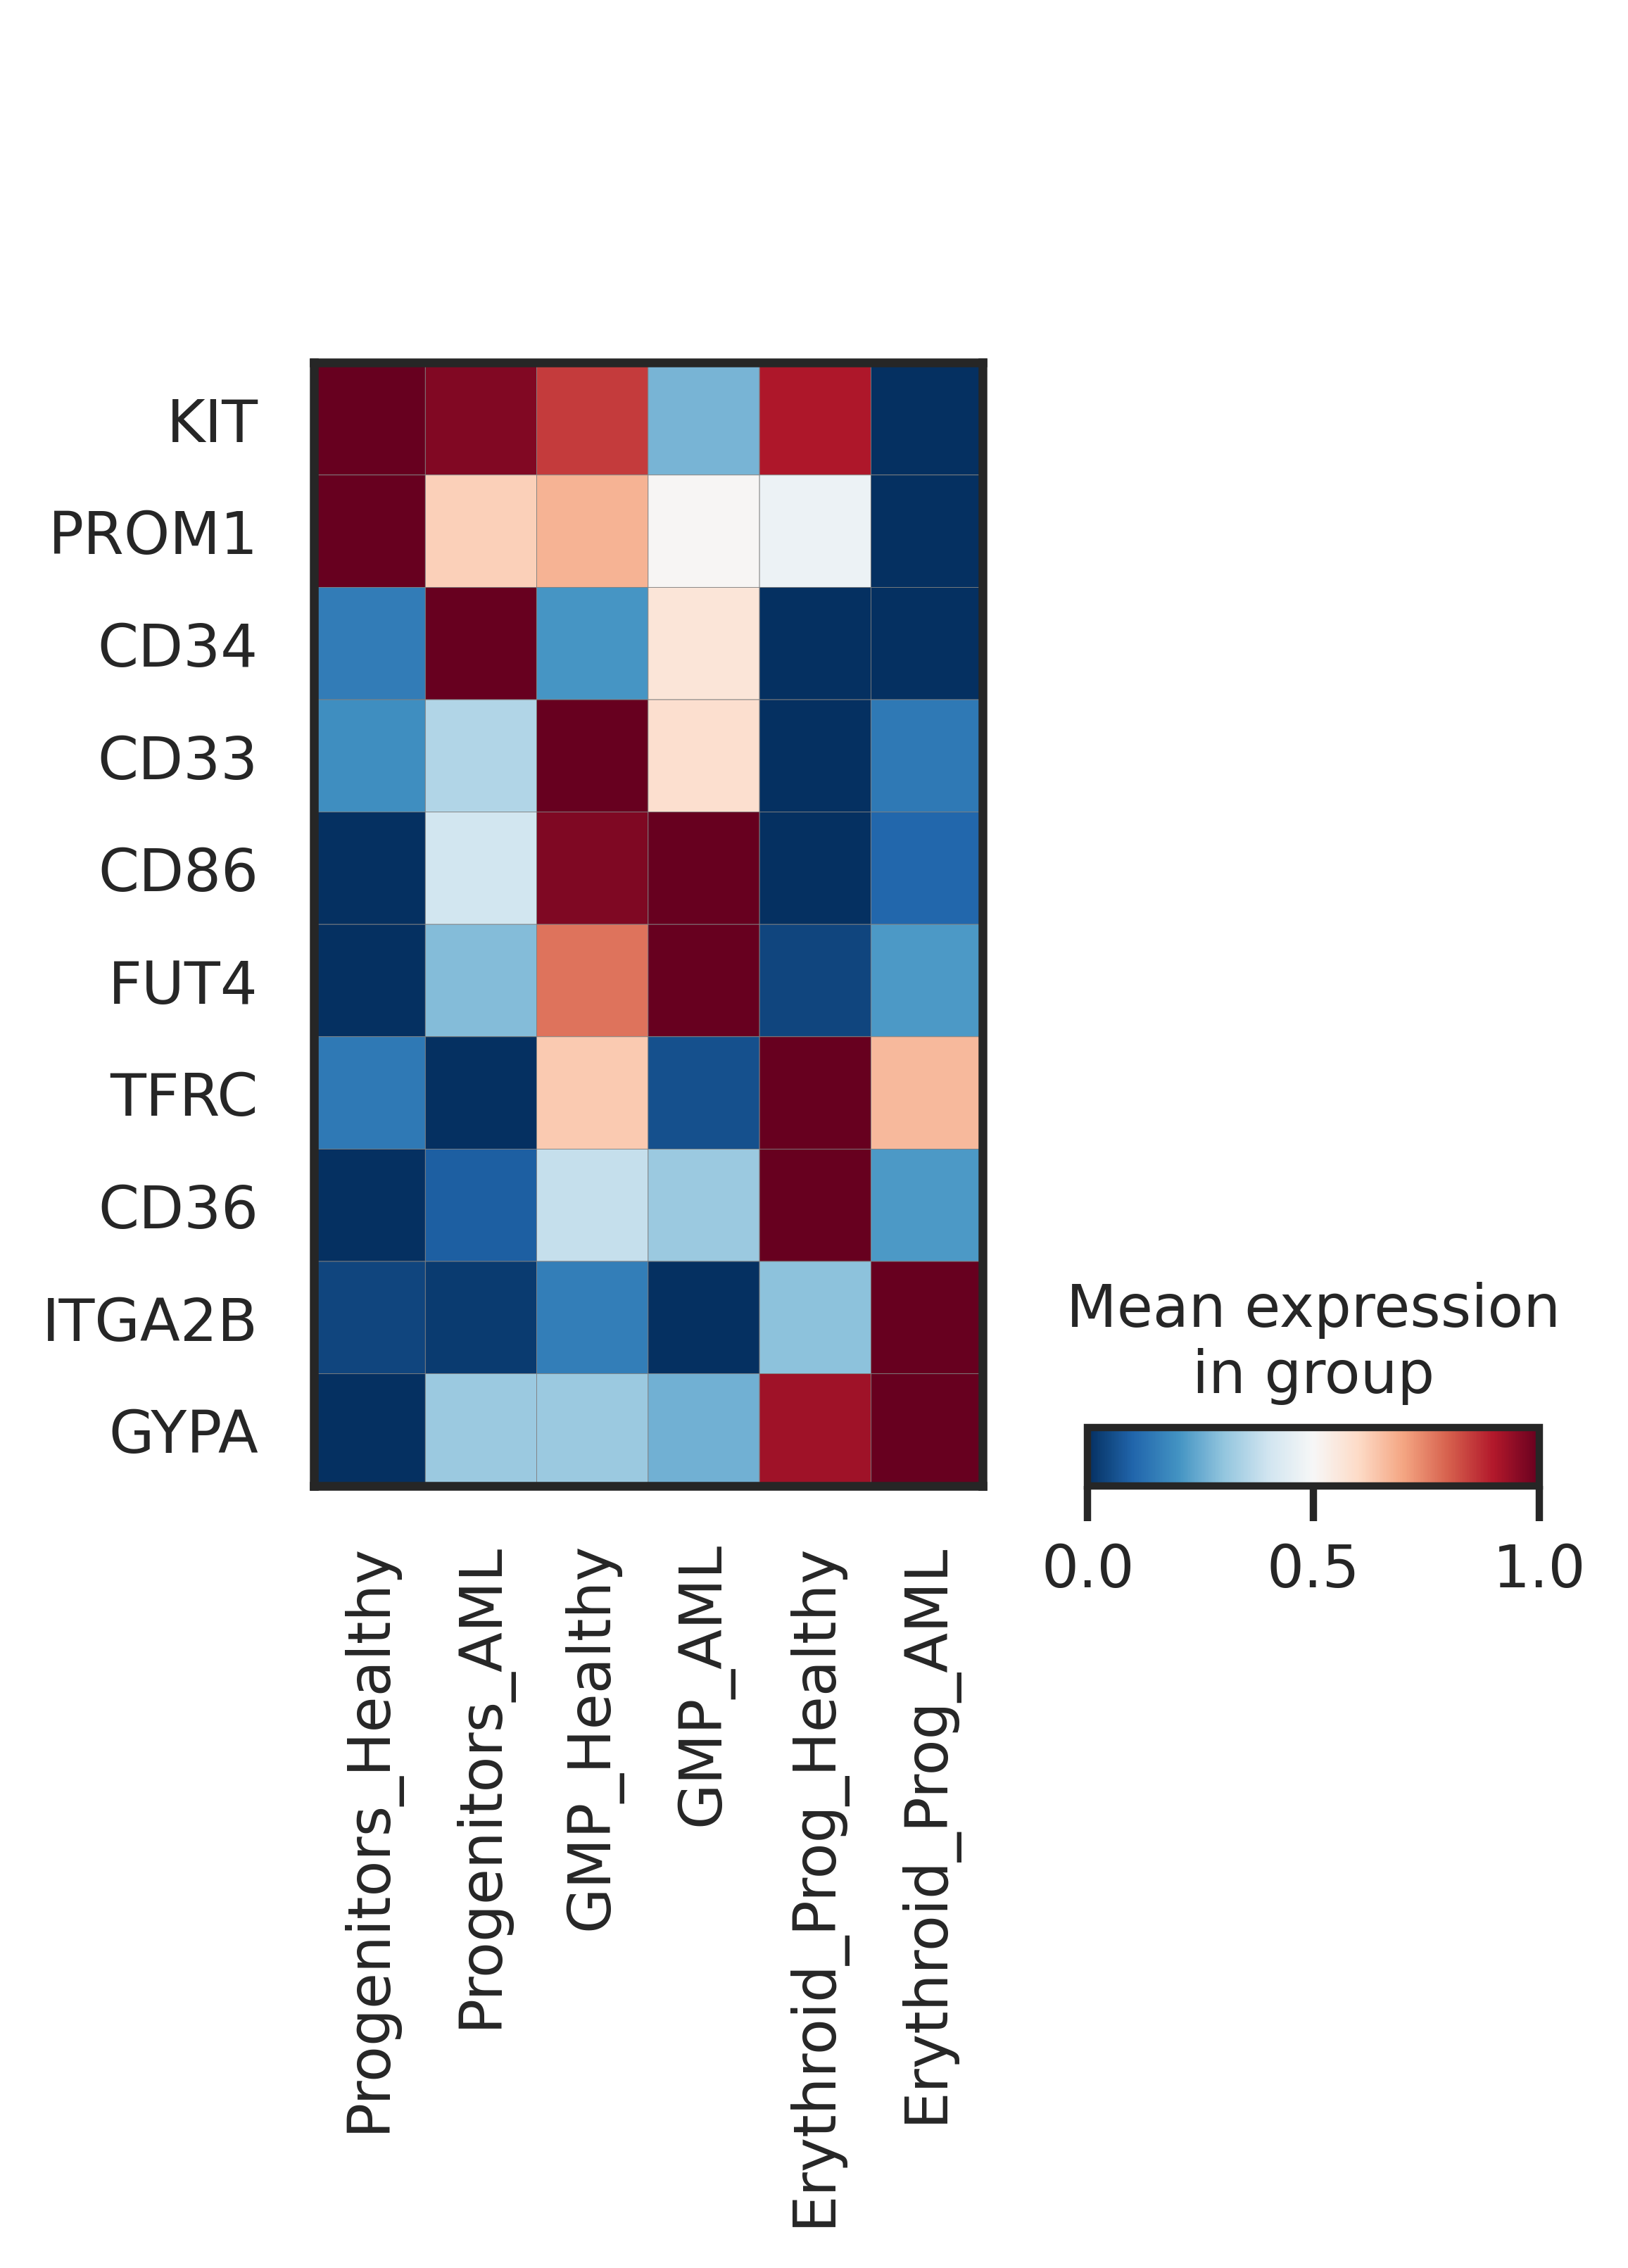

In [30]:
sc.pl.matrixplot(adata_prot[adata_prot.obs["celltype_state"].isin(["GMP_Healthy","GMP_AML","Progenitors_Healthy","Progenitors_AML","Erythroid_Prog_Healthy","Erythroid_Prog_AML"])],
                groupby = "celltype_state", 
                 var_names = ["KIT","PROM1","CD34","CD33","CD86","FUT4","TFRC","CD36","ITGA2B","GYPA"],
                standard_scale = "var",layer = "scArch_transformed_log",cmap = "RdBu_r",swap_axes = True,
                 categories_order = categories_order, save = "Markers_immunopheno.pdf")

In [150]:
GMP_GMP_like = AML_all[AML_all["rna"].obs["celltype_state"].isin(["GMP_Healthy","GMP_AML"])].copy()
GMP_GMP_like
HSPC_HSPC_like = AML_all[AML_all["rna"].obs["celltype_state"].isin(["HSC_Healthy","Progenitors_AML"])].copy()
HSPC_HSPC_like
MEP_MEP_like = AML_all[AML_all["rna"].obs["celltype_state"].isin(["Erythroid_Prog_Healthy","Erythroid_Prog_AML"])].copy()
MEP_MEP_like

MuData object with n_obs × n_vars = 32329 × 36682
  2 modalities
    rna:	32329 x 36601
      obs:	'n_genes', 'n_counts', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'sample', 'type', 'outlier', 'annotation', 'Cytogenetics', 'state', 'state_major', 'sample_major', 'immu_phe', 'EPPERT_CE_HSC_LSC', 'EPPERT_LSC_R', 'EPPERT_HSC_R', 'GAL_LEUKEMIC_STEM_CELL_UP', 'GENTLES_LEUKEMIC_STEM_CELL_UP', 'LSC104_Ng2016_UP', 'LSPC_Quiescent', 'LSPC_Primed_Top100', 'Bulk_LSC_score', 'LSC104_Ng2016_DOWN', 'MLL_LSC_Somervaille2009_UP', 'MLL_LSC_Somervaille2009_DOWN', 'LSPC_Cycle_Top100', 'GMP_like_Top100', 'ProMono_like_Top100', 'Mono_like_Top100', 'cDC_like_Top100', 'GENTLES_LEUKEMIC_STEM_CELL_DN', 'GAL_LEUKEMIC_STEM_CELL_DN', 'S_score', 'G2M_score', 'Blast_score', 'Blast_extended', 'mapped_healthy', 'malignancy_score', 'malignancy_status', 'fusion', 'fus_new', 'celltype_state'
      var:	'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
      uns:	'Cytogenetics_colors', 'annotation_colors', 'hvg', 'log1p', 'neighbors', 'pca', 'sample_colors', 'sample_major_colors', 'state_colors', 'umap'
      obsm:	'X_pca', 'X_umap', 'aucell_estimate', 'uninteg_UMAP'
      varm:	'PCs'
      layers:	'lognorm_counts', 'raw_counts'
      obsp:	'connectivities', 'distances'
    adt:	32329 x 81
      obs:	'sample', 'type', 'annotation'
      layers:	'raw_counts'

In [151]:
#surf_genes = pd.read_csv("/home/sina.kanannejad/surf_genes_v2.csv", index_col= 0)
#joint_obj = joint_obj[:,joint_obj.var_names.isin(list(surf_genes["genes"]))].copy()
#joint_obj
GMP_GMP_like = AML_all[AML_all["rna"].obs["celltype_state"].isin(["GMP_Healthy","GMP_AML"])].copy()

HSPC_HSPC_like = AML_all[AML_all["rna"].obs["celltype_state"].isin(["HSC_Healthy","Progenitors_AML"])].copy()

MEP_MEP_like = AML_all[AML_all["rna"].obs["celltype_state"].isin(["Erythroid_Prog_Healthy","Erythroid_Healthy","Erythroid_Prog_AML","Erythroid_AML"])].copy()


In [154]:
ps = pt.tl.PseudobulkSpace()
pdata = ps.compute(
    GMP_GMP_like["rna"], target_col="sample", groups_col="celltype_state", layer_key="raw_counts", mode="sum", min_cells=50, min_counts=1000
)
pdata

pds2 = pt.tl.PyDESeq2(adata=pdata, design="~type")
pds2.fit()
res_df = pds2.test_contrasts(pds2.contrast(column="type", baseline="Healthy", group_to_compare="Tumor"))
res_df

AnnData object with n_obs × n_vars = 29 × 30218
    obs: 'sample', 'celltype_state', 'type', 'Cytogenetics', 'state', 'state_major', 'sample_major', 'immu_phe', 'mapped_healthy', 'psbulk_n_cells', 'psbulk_counts'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    layers: 'psbulk_props'

In [137]:
res_df[(res_df["adj_p_value"] < 0.05) & (res_df["log_fc"] < 2)].sort_values(by = "log_fc", ascending = False)[0:30]

variable    baseMean    log_fc     lfcSE      stat       p_value  \
39       NUDT18   72.863610  1.924134  0.444886  4.325002  1.525306e-05   
133        DFFB   90.690676  1.916753  0.535720  3.577905  3.463596e-04   
107       MYO1G  366.865916  1.898185  0.509945  3.722334  1.973901e-04   
53      PIP5K1C   81.284724  1.852898  0.444337  4.170026  3.045651e-05   
42       ANKZF1   77.321100  1.842665  0.431241  4.272936  1.929156e-05   
96   AC099343.3   47.819810  1.839211  0.486816  3.778038  1.580686e-04   
79   AC097634.3  111.440885  1.801762  0.462913  3.892224  9.932940e-05   
113        NCF4  466.186073  1.785495  0.482988  3.696765  2.183645e-04   
122      DNAJA3  101.512665  1.781799  0.487297  3.656495  2.556871e-04   
38      NNT-AS1   69.686612  1.779771  0.410205  4.338737  1.433040e-05   
52        INTS6  318.045865  1.772885  0.425077  4.170743  3.036076e-05   
106       APBA3   45.458253  1.757577  0.472141  3.722569  1.972058e-04   
131        TCTA  130.384148  1.753474  0.486298  3.605757  3.112442e-04   
102       INTS3  147.639818  1.705811  0.454789  3.750776  1.762884e-04   
145     PPP1R10  403.343807  1.699656  0.479824  3.542246  3.967348e-04   
100        IRF2  127.473642  1.624522  0.432971  3.752034  1.754058e-04   
74        TM2D3   94.028935  1.606179  0.409224  3.924935  8.675319e-05   
72         FGGY  123.128498  1.564837  0.395710  3.954507  7.669258e-05   
16        MITD1  152.391597  1.552908  0.316711  4.903228  9.427446e-07   
139    SLC39A10  293.069086  1.551299  0.435455  3.562473  3.673773e-04   
105        GDI1  104.859345  1.550709  0.415300  3.733948  1.885017e-04   
69       ZNF720   92.436266  1.549004  0.389771  3.974140  7.063402e-05   
50     LRRC37A3  119.384473  1.483366  0.354157  4.188444  2.808732e-05   
26      ILF3-DT  252.142156  1.461133  0.317390  4.603587  4.152763e-06   
71   AC025159.1  240.773353  1.385966  0.350217  3.957452  7.575338e-05   
75      ARL6IP5  693.702523  1.378396  0.351653  3.919763  8.863622e-05   
99        LRP10   98.835815  1.351596  0.359778  3.756756  1.721302e-04   
68         EEA1  293.010368  1.303893  0.326853  3.989233  6.628739e-05   
83         COA6  185.289213  1.251309  0.324082  3.861094  1.128806e-04   
94        DESI1  127.679420  1.248596  0.328195  3.804427  1.421331e-04   

     adj_p_value contrast  
39      0.006954     None  
133     0.047292     None  
107     0.033111     None  
53      0.010218     None  
42      0.008167     None  
96      0.029585     None  
79      0.022643     None  
113     0.034667     None  
122     0.037573     None  
38      0.006705     None  
52      0.010218     None  
106     0.033111     None  
131     0.043236     None  
102     0.031035     None  
145     0.049678     None  
100     0.031035     None  
74      0.020845     None  
72      0.018940     None  
16      0.000986     None  
139     0.048032     None  
105     0.032228     None  
69      0.018202     None  
50      0.009988     None  
26      0.002840     None  
71      0.018940     None  
75      0.021014     None  
99      0.031035     None  
68      0.017333     None  
83      0.024405     None  
94      0.027175     None

NaNs encountered, dropping rows with NaNs


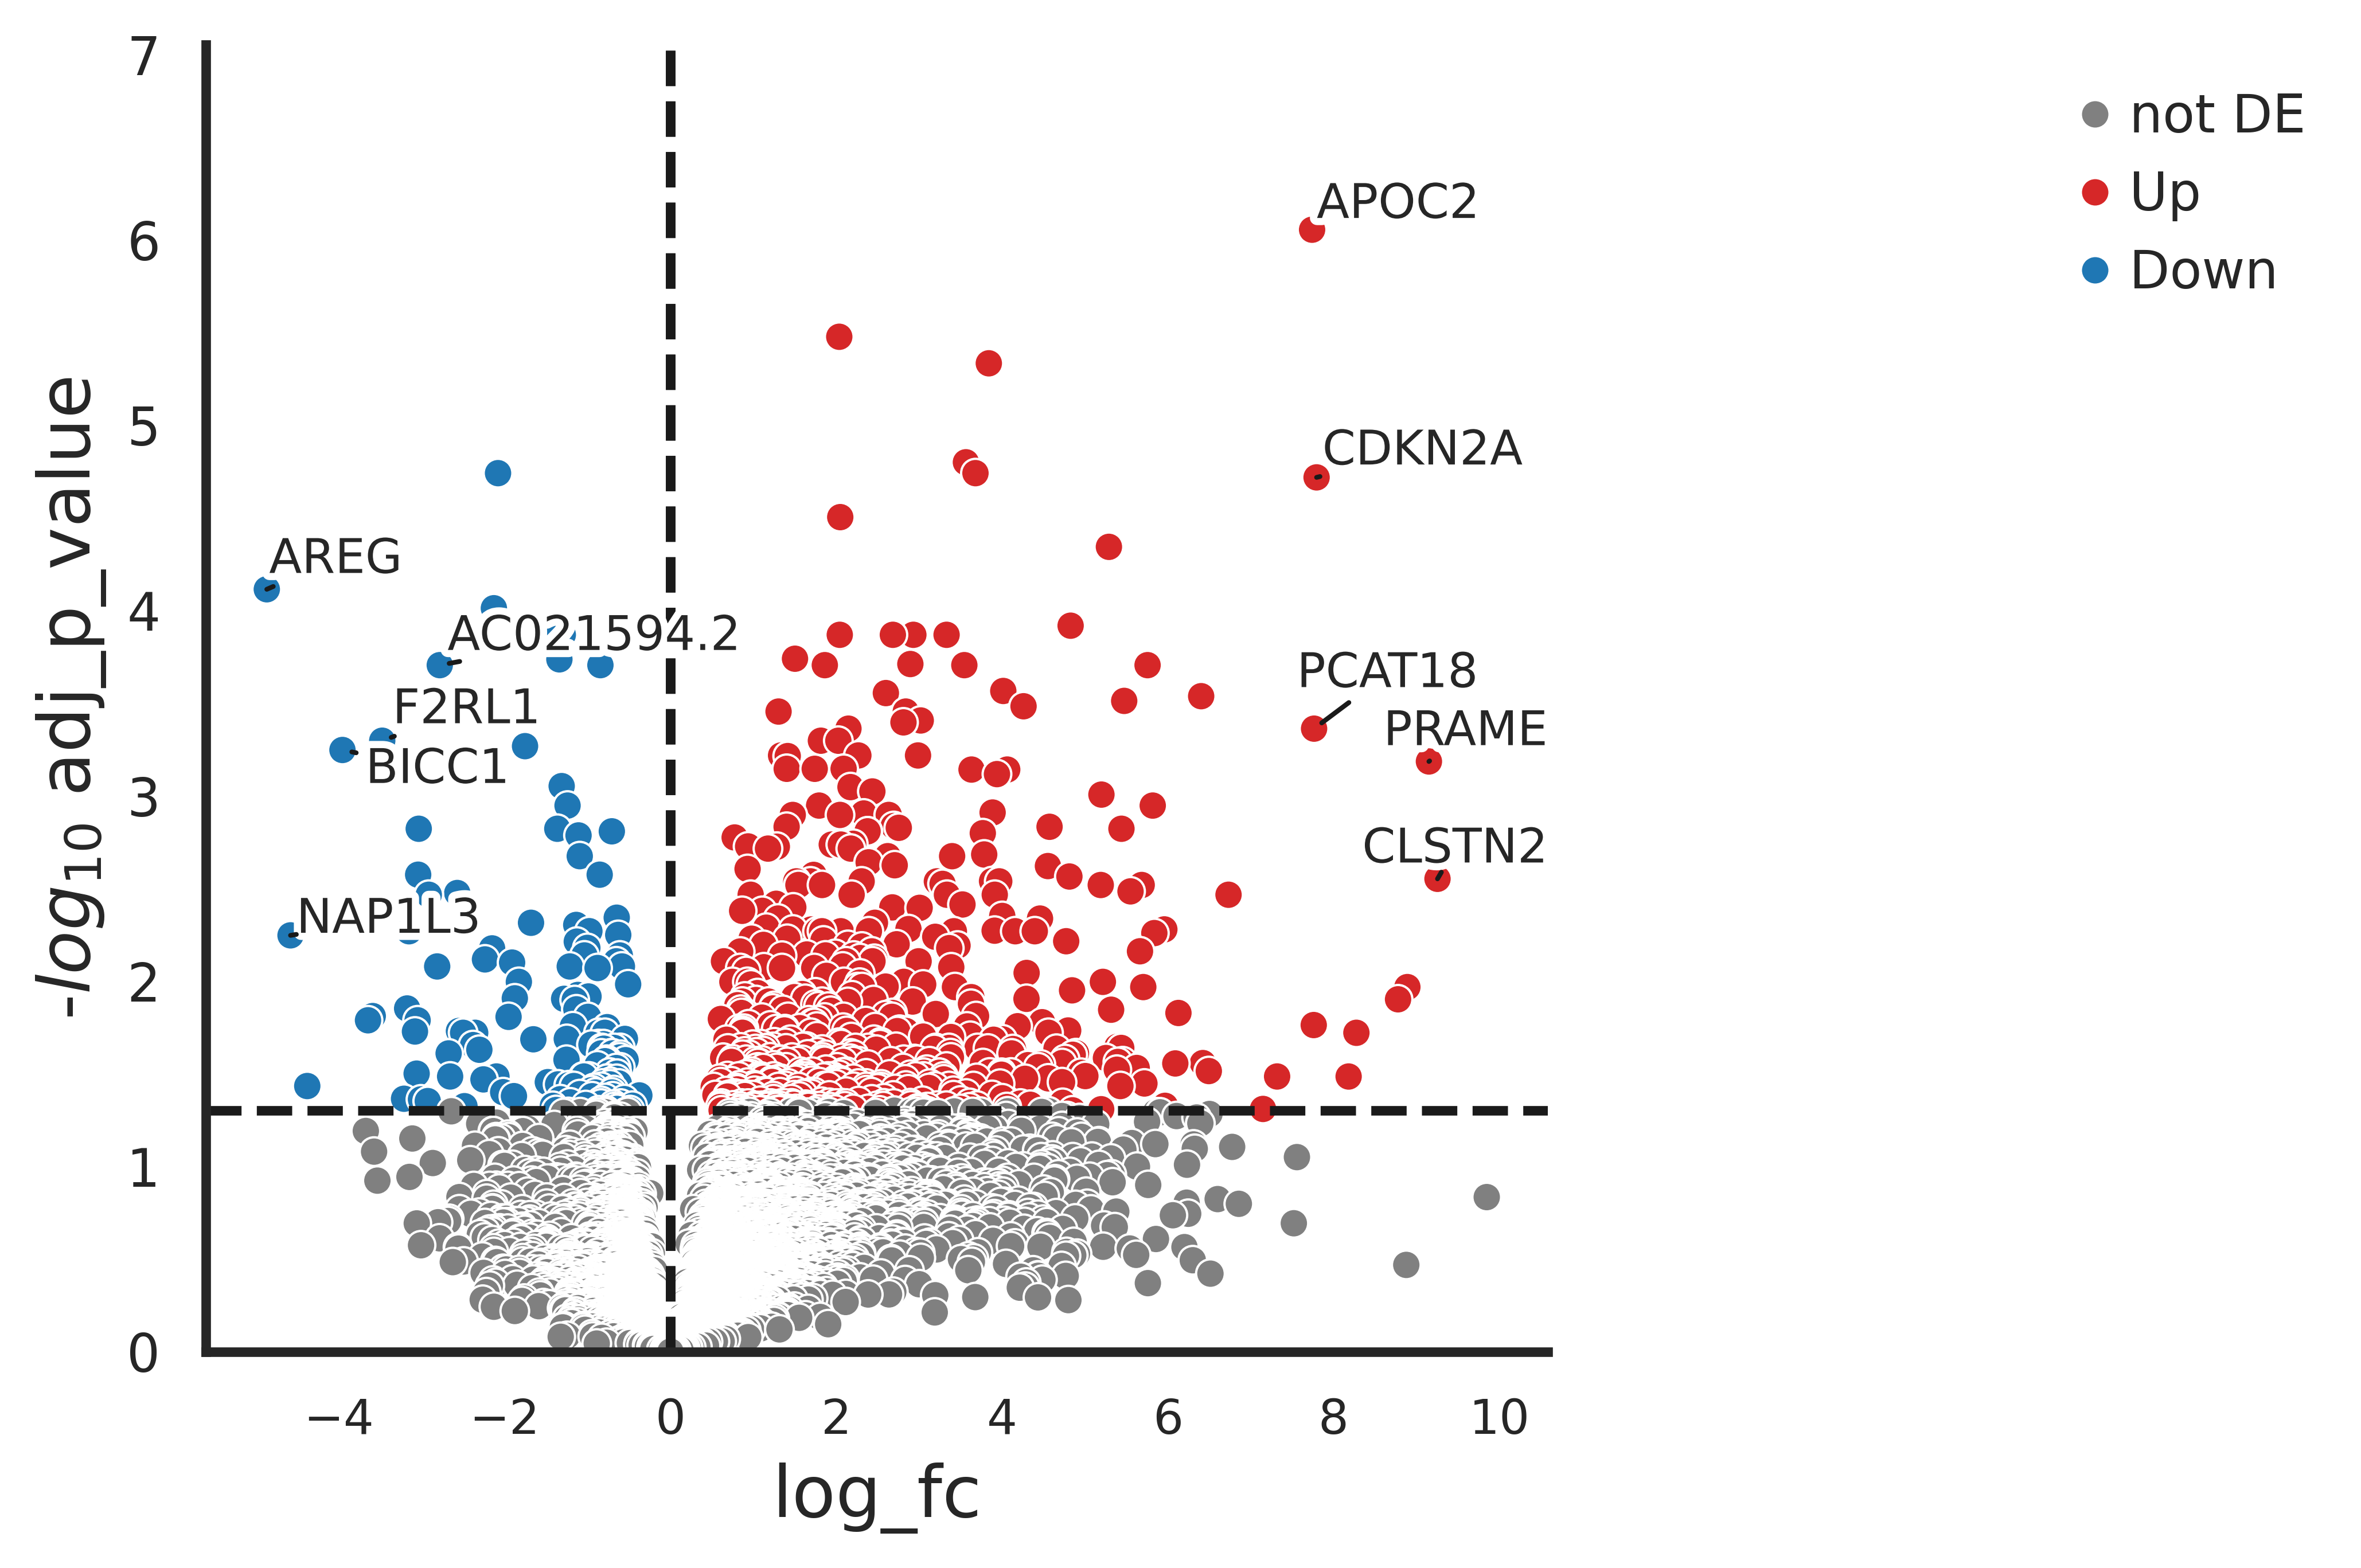

In [158]:
pds2.plot_volcano(res_df, log2fc_thresh=0, save = True)

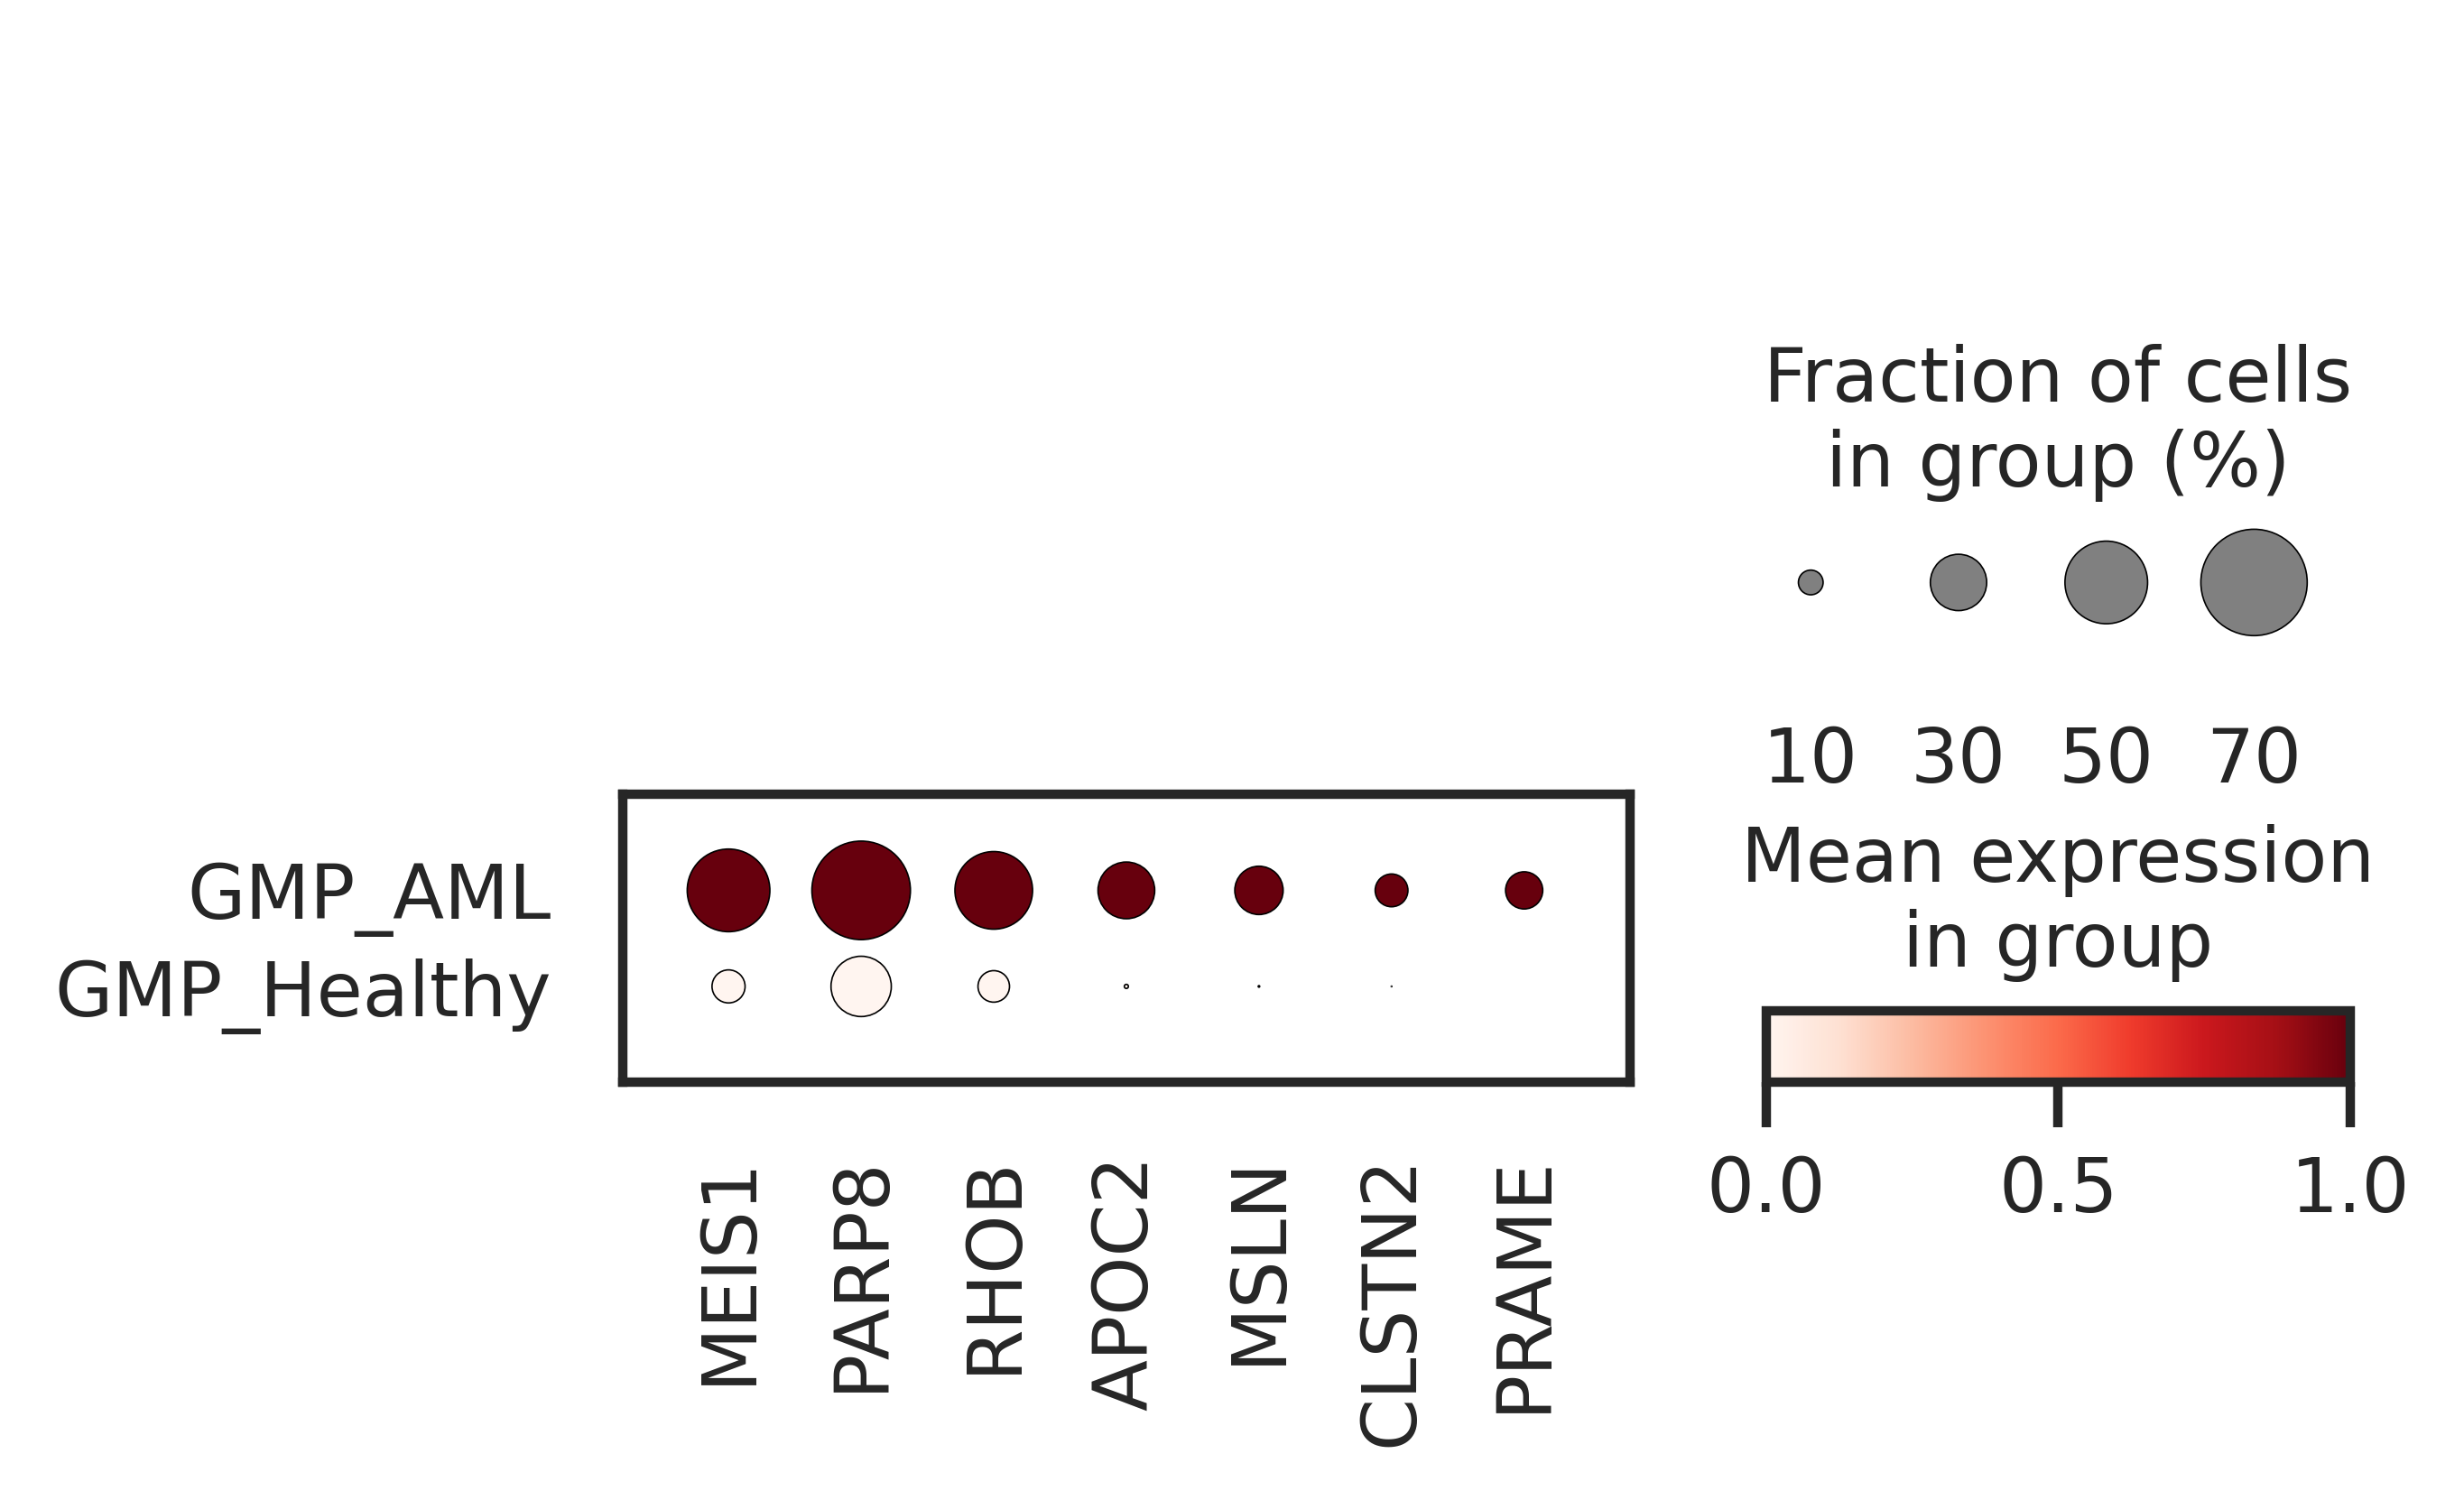

In [159]:
sc.pl.dotplot(GMP_GMP_like["rna"], var_names = ["MEIS1","PARP8","RHOB","APOC2","MSLN","CLSTN2","PRAME"],
              groupby = "celltype_state", standard_scale = "var")

In [160]:
ps = pt.tl.PseudobulkSpace()
pdata = ps.compute(
    HSPC_HSPC_like["rna"], target_col="sample", groups_col="celltype_state", layer_key="raw_counts", mode="sum", min_cells=50, min_counts=2000
)

pds2 = pt.tl.PyDESeq2(adata=pdata, design="~type")
pds2.fit()
res_df = pds2.test_contrasts(pds2.contrast(column="type", baseline="Healthy", group_to_compare="Tumor"))
res_df

AnnData object with n_obs × n_vars = 31 × 30969
    obs: 'sample', 'celltype_state', 'type', 'Cytogenetics', 'state', 'state_major', 'sample_major', 'immu_phe', 'mapped_healthy', 'psbulk_n_cells', 'psbulk_counts'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    layers: 'psbulk_props'

In [154]:
res_df[(res_df["adj_p_value"] < 0.05) & (res_df["log_fc"] < -4)].sort_values(by = "baseMean", ascending = False)[0:30]

variable     baseMean    log_fc     lfcSE      stat       p_value  \
23           AVP  2159.396630 -7.624566  1.247351 -6.112607  9.801650e-10   
791         BEX1   288.930260 -4.989757  1.334995 -3.737658  1.857423e-04   
1648       MFAP2    59.531199 -4.051006  1.288130 -3.144875  1.661579e-03   
1506       LDOC1    47.691842 -4.436299  1.377761 -3.219934  1.282199e-03   
77        LIMCH1    44.120312 -5.321553  0.986307 -5.395431  6.835940e-08   
29          EMCN    40.775010 -5.035106  0.843440 -5.969728  2.376500e-09   
1870       UCHL1    35.479338 -4.443401  1.465028 -3.032979  2.421522e-03   
503        NPAS3    34.585403 -4.165625  1.026476 -4.058179  4.945680e-05   
99    AC011139.1    29.402838 -7.559576  1.450256 -5.212582  1.862303e-07   
125          OXT    28.226522 -4.044043  0.801838 -5.043468  4.571704e-07   
380       MIPOL1    21.713222 -4.432337  1.049719 -4.222404  2.417106e-05   
451       CLEC3B    19.972157 -4.678422  1.136381 -4.116947  3.839235e-05   
2279      TMEM98    19.864919 -4.212579  1.470209 -2.865293  4.166234e-03   
36          PCLO    13.837288 -4.242277  0.724501 -5.855450  4.757192e-09   
242           KL    12.302657 -5.002296  1.101483 -4.541419  5.587676e-06   
928       NUDT11    12.140879 -5.061231  1.402377 -3.609037  3.073358e-04   
149       SLC1A6    12.048892 -6.317541  1.280455 -4.933823  8.063551e-07   
18          CNMD    11.616226 -4.657138  0.729839 -6.381049  1.758786e-10   
1820       HIF3A    11.088427 -4.364153  1.424181 -3.064326  2.181613e-03   
345        PWRN1     9.647688 -4.583965  1.063418 -4.310596  1.628148e-05   
270       TCEAL2     9.611238 -7.801901  1.743865 -4.473914  7.680047e-06   
92      CDC42EP5     9.143805 -4.997598  0.950118 -5.259974  1.440757e-07   
470   AC009041.2     8.636618 -5.248639  1.280986 -4.097342  4.179210e-05   
931        IQCA1     8.487325 -4.314663  1.197252 -3.603804  3.135934e-04   
3           SGCZ     7.369724 -6.416441  0.847702 -7.569217  3.754813e-14   
1344     C2orf66     7.162344 -4.991560  1.508541 -3.308866  9.367467e-04   
161         MSMP     6.855829 -4.114070  0.845619 -4.865157  1.143659e-06   
109   AC105942.1     6.837331 -4.270228  0.833331 -5.124290  2.986612e-07   
466     ARHGAP29     6.133912 -4.493683  1.095568 -4.101691  4.101412e-05   
609         CDH7     6.094452 -5.443079  1.388882 -3.919036  8.890398e-05   

       adj_p_value contrast  
23    6.739451e-07     None  
791   3.965227e-03     None  
1648  1.711572e-02     None  
1506  1.447254e-02     None  
77    1.465022e-05     None  
29    1.307233e-06     None  
1870  2.198018e-02     None  
503   1.658813e-03     None  
99    3.104215e-05     None  
125   6.035381e-05     None  
380   1.070794e-03     None  
451   1.439336e-03     None  
2279  3.098296e-02     None  
36    2.082800e-06     None  
242   3.874279e-04     None  
928   5.604039e-03     None  
149   8.990859e-05     None  
18    1.527552e-07     None  
1820  2.032805e-02     None  
345   7.949025e-04     None  
270   4.782496e-04     None  
92    2.584279e-05     None  
470   1.502512e-03     None  
931   5.699249e-03     None  
3     1.549048e-10     None  
1344  1.185444e-02     None  
161   1.179541e-04     None  
109   4.521566e-05     None  
466   1.487506e-03     None  
609   2.465703e-03     None

NaNs encountered, dropping rows with NaNs


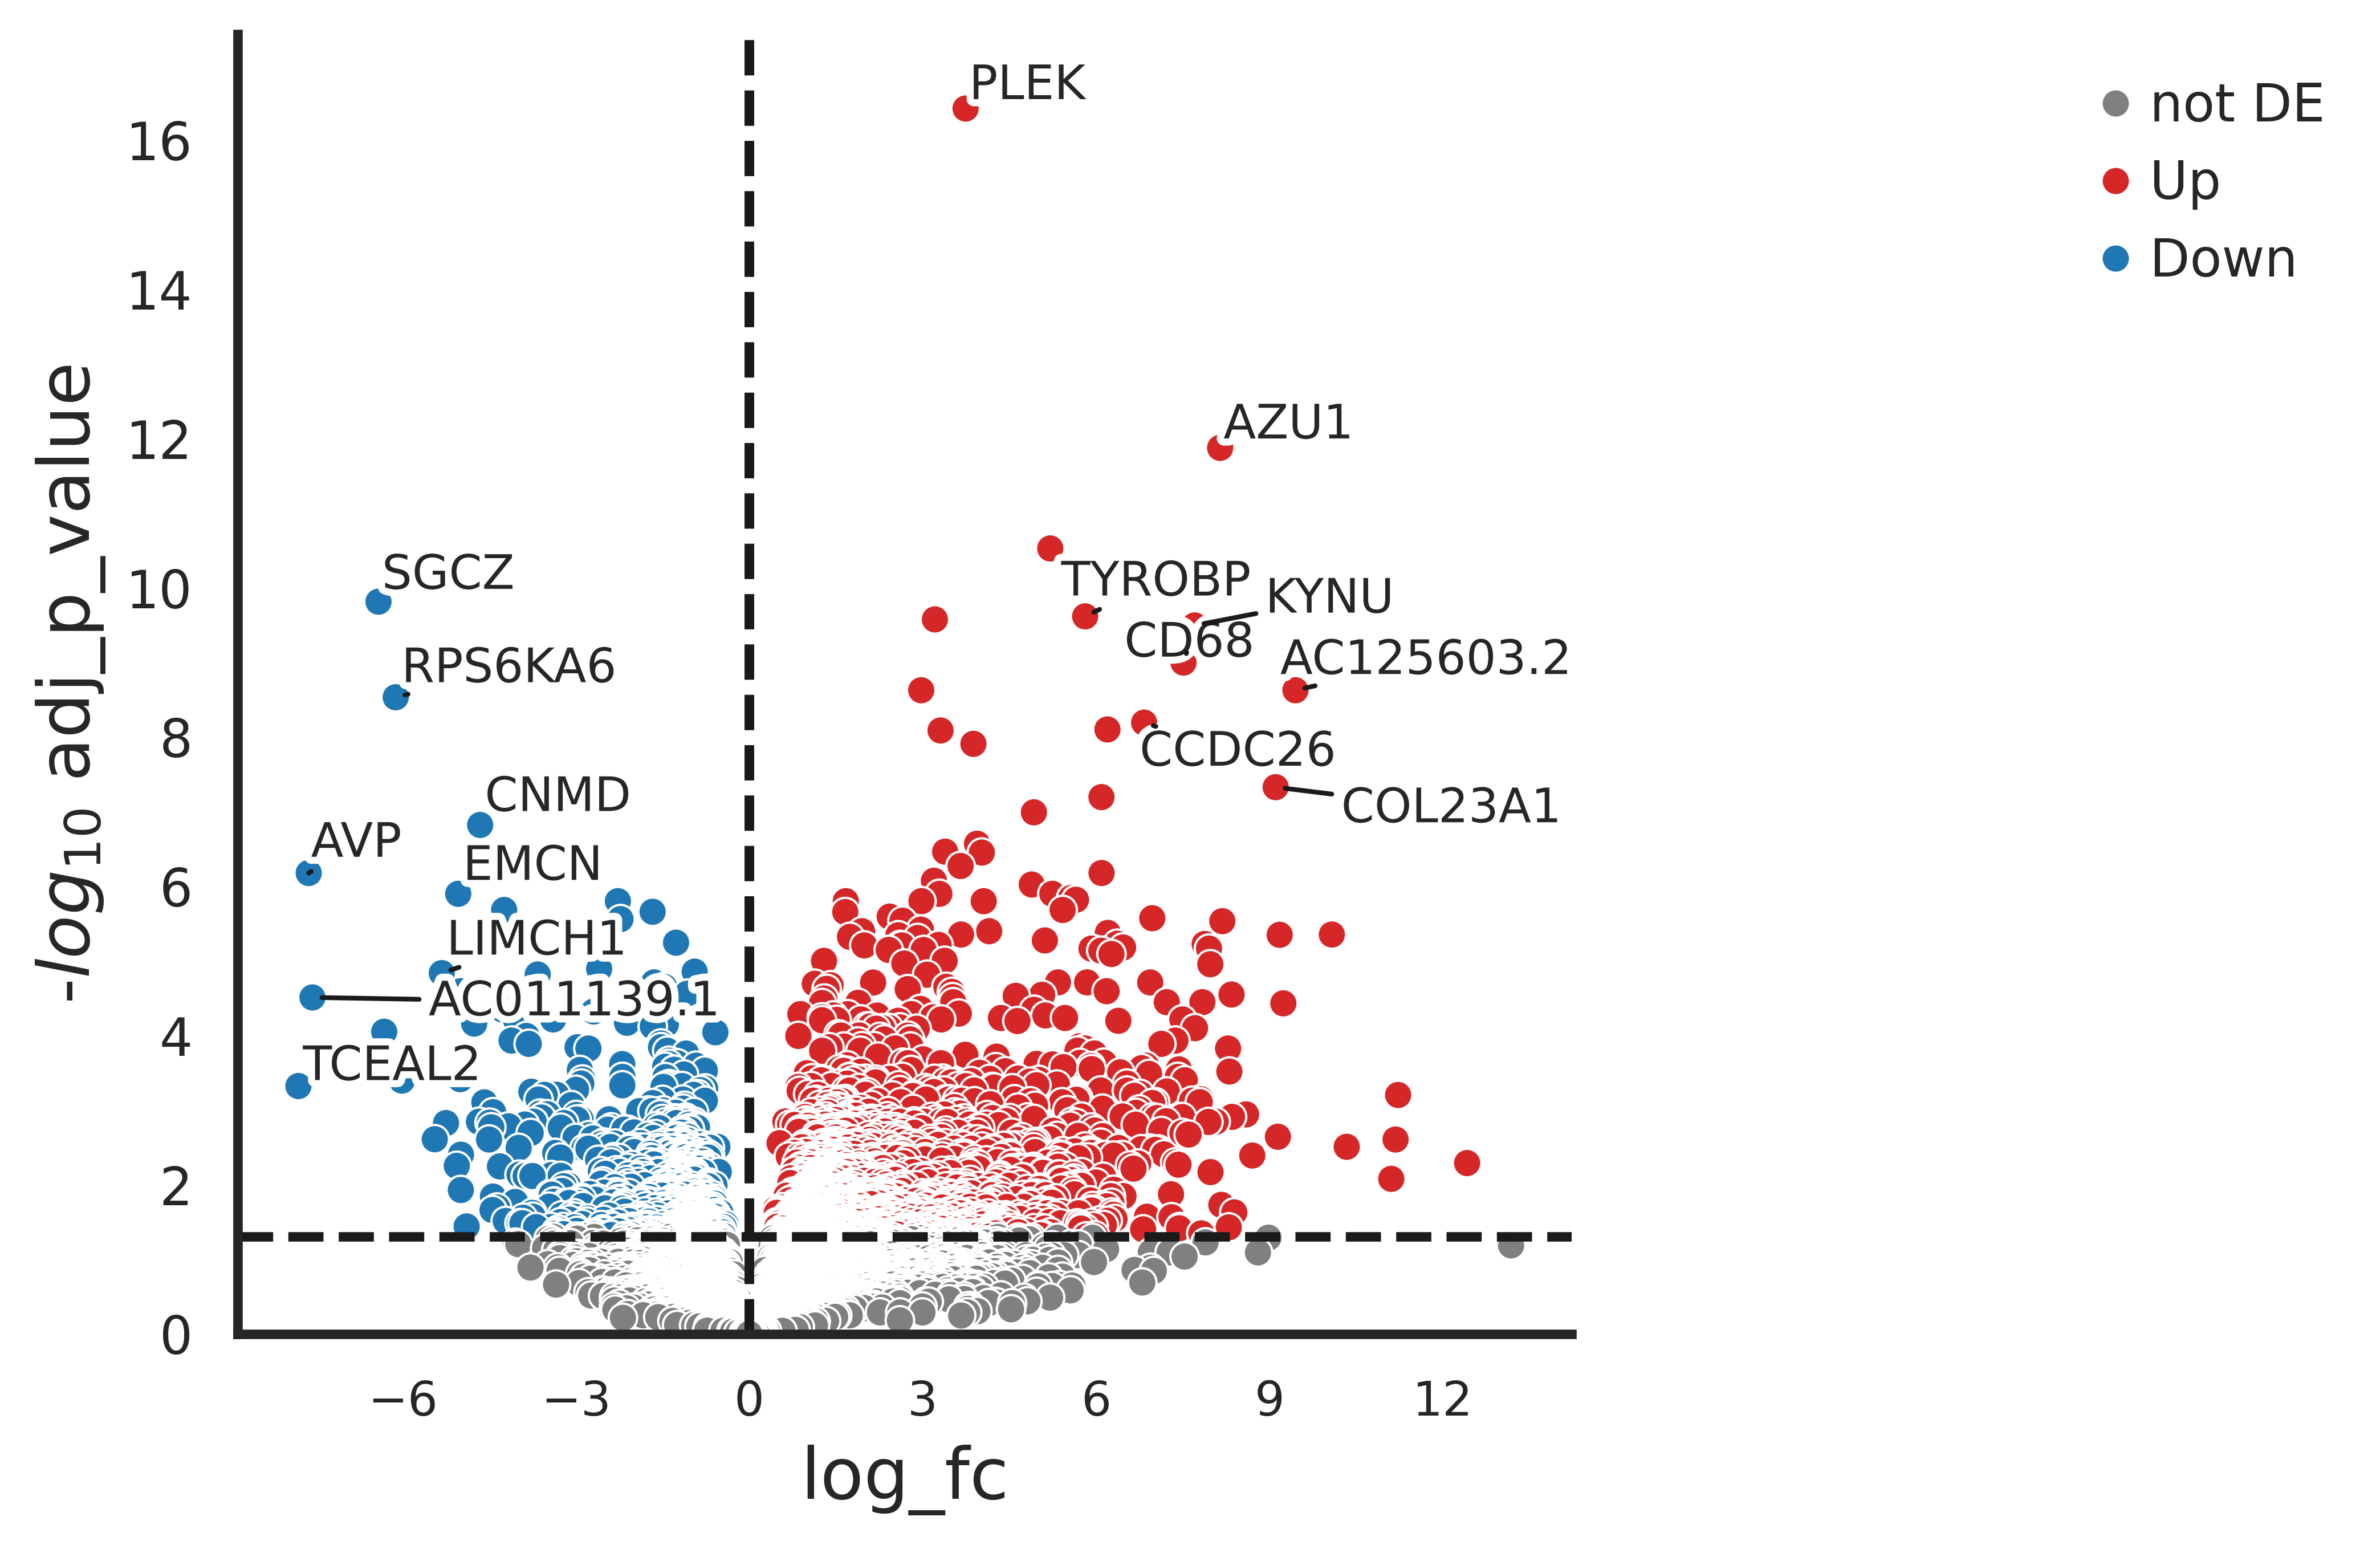

In [163]:
pds2.plot_volcano(res_df, log2fc_thresh=0, to_label = 8, save = True)

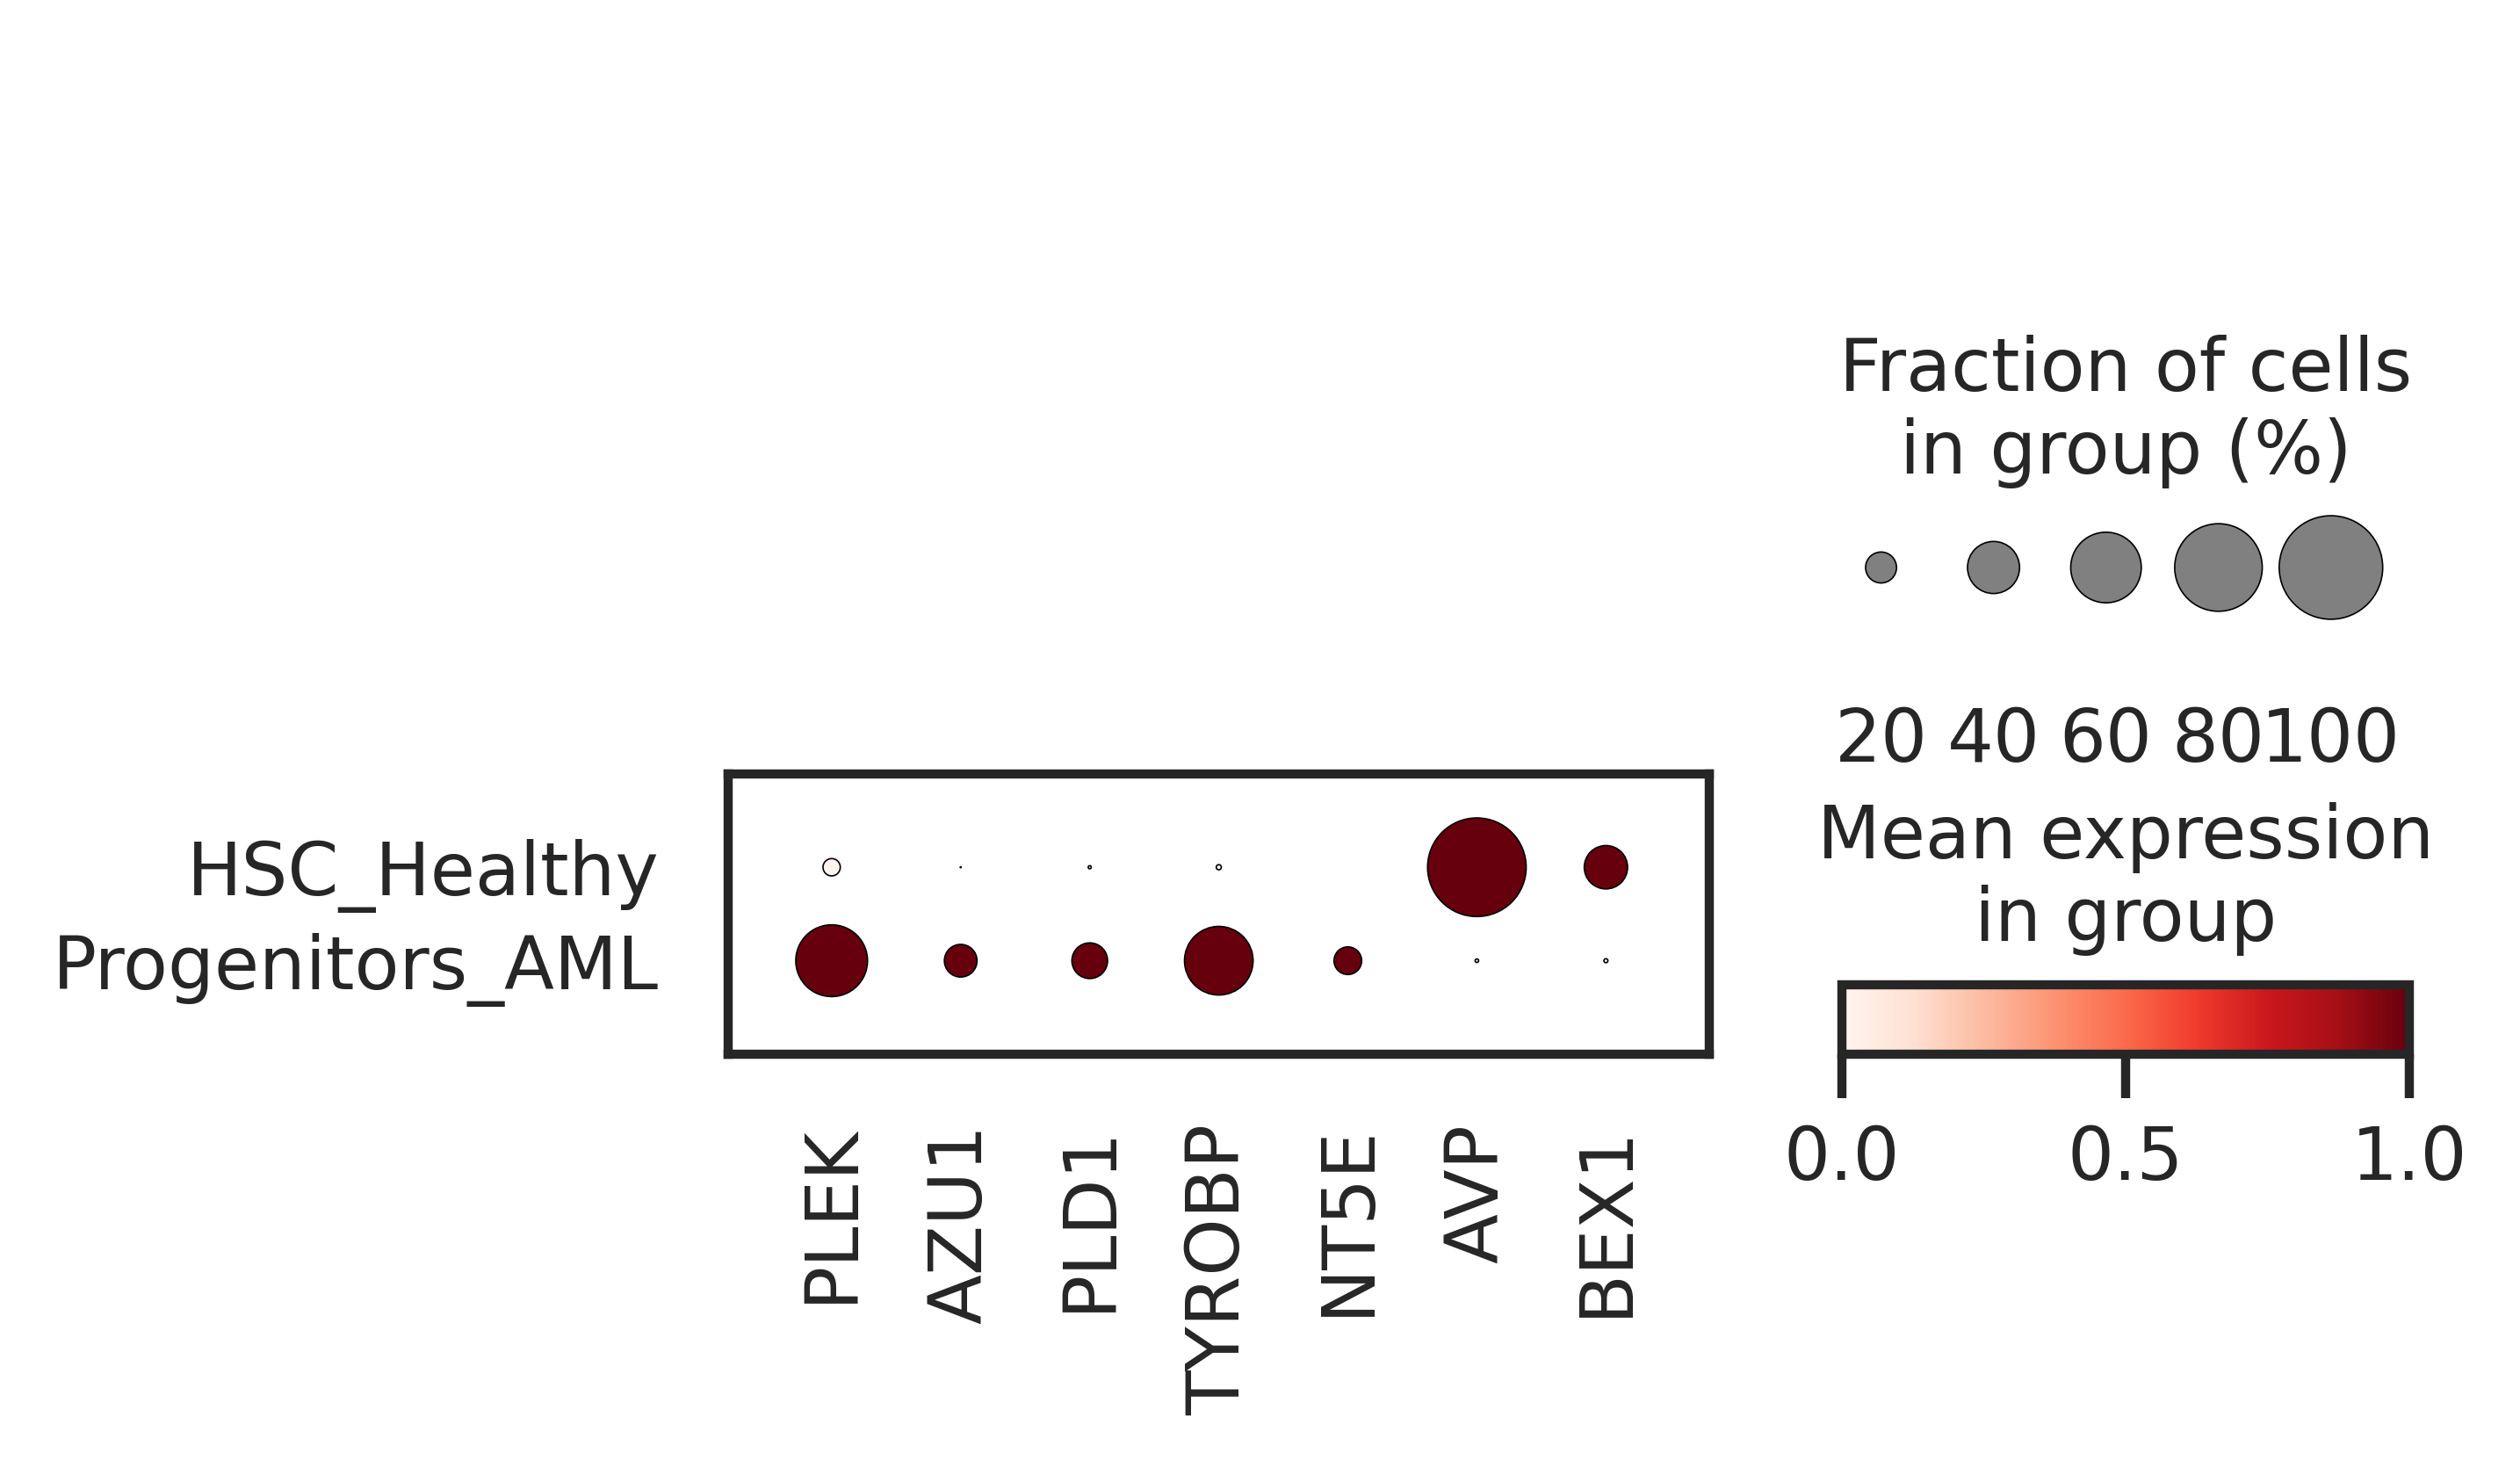

In [165]:
sc.pl.dotplot(HSPC_HSPC_like["rna"], var_names = ["PLEK","AZU1","PLD1","TYROBP","NT5E","AVP","BEX1"],
              groupby = "celltype_state", standard_scale = "var")

In [167]:
ps = pt.tl.PseudobulkSpace()
pdata = ps.compute(
    MEP_MEP_like["rna"], target_col="sample", groups_col="celltype_state", layer_key="raw_counts", mode="sum", min_cells=50, min_counts=2000
)

pds2 = pt.tl.PyDESeq2(adata=pdata, design="~type")
pds2.fit()
res_df = pds2.test_contrasts(pds2.contrast(column="type", baseline="Healthy", group_to_compare="Tumor"))
res_df

AnnData object with n_obs × n_vars = 45 × 31030
    obs: 'sample', 'celltype_state', 'type', 'Cytogenetics', 'state', 'state_major', 'sample_major', 'immu_phe', 'mapped_healthy', 'psbulk_n_cells', 'psbulk_counts'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    layers: 'psbulk_props'

In [187]:
res_df[(res_df["adj_p_value"] < 0.05) & (res_df["log_fc"] > 7)].sort_values(by = "baseMean", ascending = False)[0:50]

variable    baseMean     log_fc     lfcSE      stat       p_value  \
1          CXCL8  636.606983   7.025048  1.003879  6.997906  2.598163e-12   
244    MTRNR2L12  466.037985   7.366112  1.722607  4.276141  1.901608e-05   
20        HOMER3  226.486818   7.105893  1.202540  5.909067  3.440500e-09   
19         PRAME  130.666898  11.366522  1.907512  5.958820  2.540663e-09   
18    AC125603.2  127.565905   9.609225  1.611841  5.961645  2.497117e-09   
37    AL392086.3  106.013195   7.703864  1.411059  5.459631  4.771239e-08   
502      PHACTR3  102.564615   7.906370  2.074301  3.811583  1.380799e-04   
426        HOXB9   49.222669   9.873450  2.523755  3.912206  9.145690e-05   
176      GALNTL6   46.261590   9.863886  2.188576  4.506988  6.575443e-06   
722          FEV   41.980108   7.102468  2.020867  3.514565  4.404748e-04   
253       ADGRG7   40.849698   9.693886  2.273514  4.263834  2.009489e-05   
10          CCL3   40.207450   7.653563  1.217944  6.284004  3.299625e-10   
132       CCL3L1   37.933987   8.991095  1.916849  4.690559  2.724601e-06   
296        FOXC1   36.024655   7.152528  1.709874  4.183072  2.875960e-05   
1152      DUXAP8   30.267015   7.086136  2.253950  3.143874  1.667272e-03   
141   AC104232.1   29.889235   8.646967  1.859008  4.651388  3.297079e-06   
758       HOXA11   29.572634   8.633341  2.481962  3.478433  5.043538e-04   
187      GOLGA8M   28.429221   7.994881  1.793731  4.457123  8.306686e-06   
280       CLSTN2   27.198828   8.518762  2.021422  4.214242  2.506188e-05   
681       LRATD1   25.218948   8.332903  2.346378  3.551390  3.832019e-04   
659         PPIC   22.972688   8.856709  2.472824  3.581617  3.414747e-04   
231      PPP1R27   22.525207   7.060830  1.642591  4.298594  1.718850e-05   
728   HOMER3-AS1   22.171580   8.810691  2.511753  3.507785  4.518534e-04   
215   AC027601.6   21.360544   7.581283  1.738277  4.361379  1.292455e-05   
433      SLITRK5   19.244562   7.479109  1.918819  3.897766  9.708424e-05   
460   AC026167.1   18.940026   7.430998  1.925383  3.859491  1.136236e-04   
919        PCDH7   17.019284   8.413711  2.534491  3.319685  9.011923e-04   
257   AC027601.1   16.315546   7.626970  1.790693  4.259228  2.051343e-05   
742   AC104809.2   16.091559   7.782166  2.225407  3.496963  4.705865e-04   
1170       OLFM3   14.492464   8.199073  2.616355  3.133777  1.725718e-03   
1445        NCR2   13.301289   7.445638  2.503436  2.974168  2.937841e-03   
1439       HOXB8   12.876133   8.027267  2.695622  2.977890  2.902401e-03   
286     CABCOCO1   12.331533   7.414697  1.767086  4.196002  2.716675e-05   
674        TRBVB   10.567486   7.747889  2.177621  3.557961  3.737448e-04   
726    LINC01436    9.978536   7.661767  2.182713  3.510203  4.477640e-04   
1281       IL23R    9.844053   7.649678  2.496712  3.063900  2.184717e-03   
1639  AC004080.2    9.658149   7.605877  2.640530  2.880435  3.971263e-03   
1141  AC125603.1    7.789086   7.331456  2.326911  3.150725  1.628659e-03   
739        LPAR1    7.315911   7.233992  2.066983  3.499783  4.656363e-04   
891   AC087857.1    7.016766   7.106158  2.122139  3.348583  8.122606e-04   
719       FCGR1B    6.848487   7.101856  2.019106  3.517327  4.359171e-04   
1549        AGXT    6.550169   7.006518  2.395071  2.925391  3.440238e-03   

       adj_p_value contrast  
1     1.766029e-08     None  
244   1.449432e-03     None  
20    3.078265e-06     None  
19    2.386826e-06     None  
18    2.386826e-06     None  
37    2.312875e-05     None  
502   5.157819e-03     None  
426   4.024318e-03     None  
176   6.951010e-04     None  
722   1.143214e-02     None  
253   1.486468e-03     None  
10    5.636059e-07     None  
132   3.849063e-04     None  
296   1.817799e-03     None  
1152  2.713254e-02     None  
141   4.362593e-04     None  
758   1.248525e-02     None  
187   8.301826e-04     None  
280   1.672342e-03     None  
681   1.055716e-02     None  
659   9.721164e-03     None  
231   1.392047e-03     None  
728   

NaNs encountered, dropping rows with NaNs


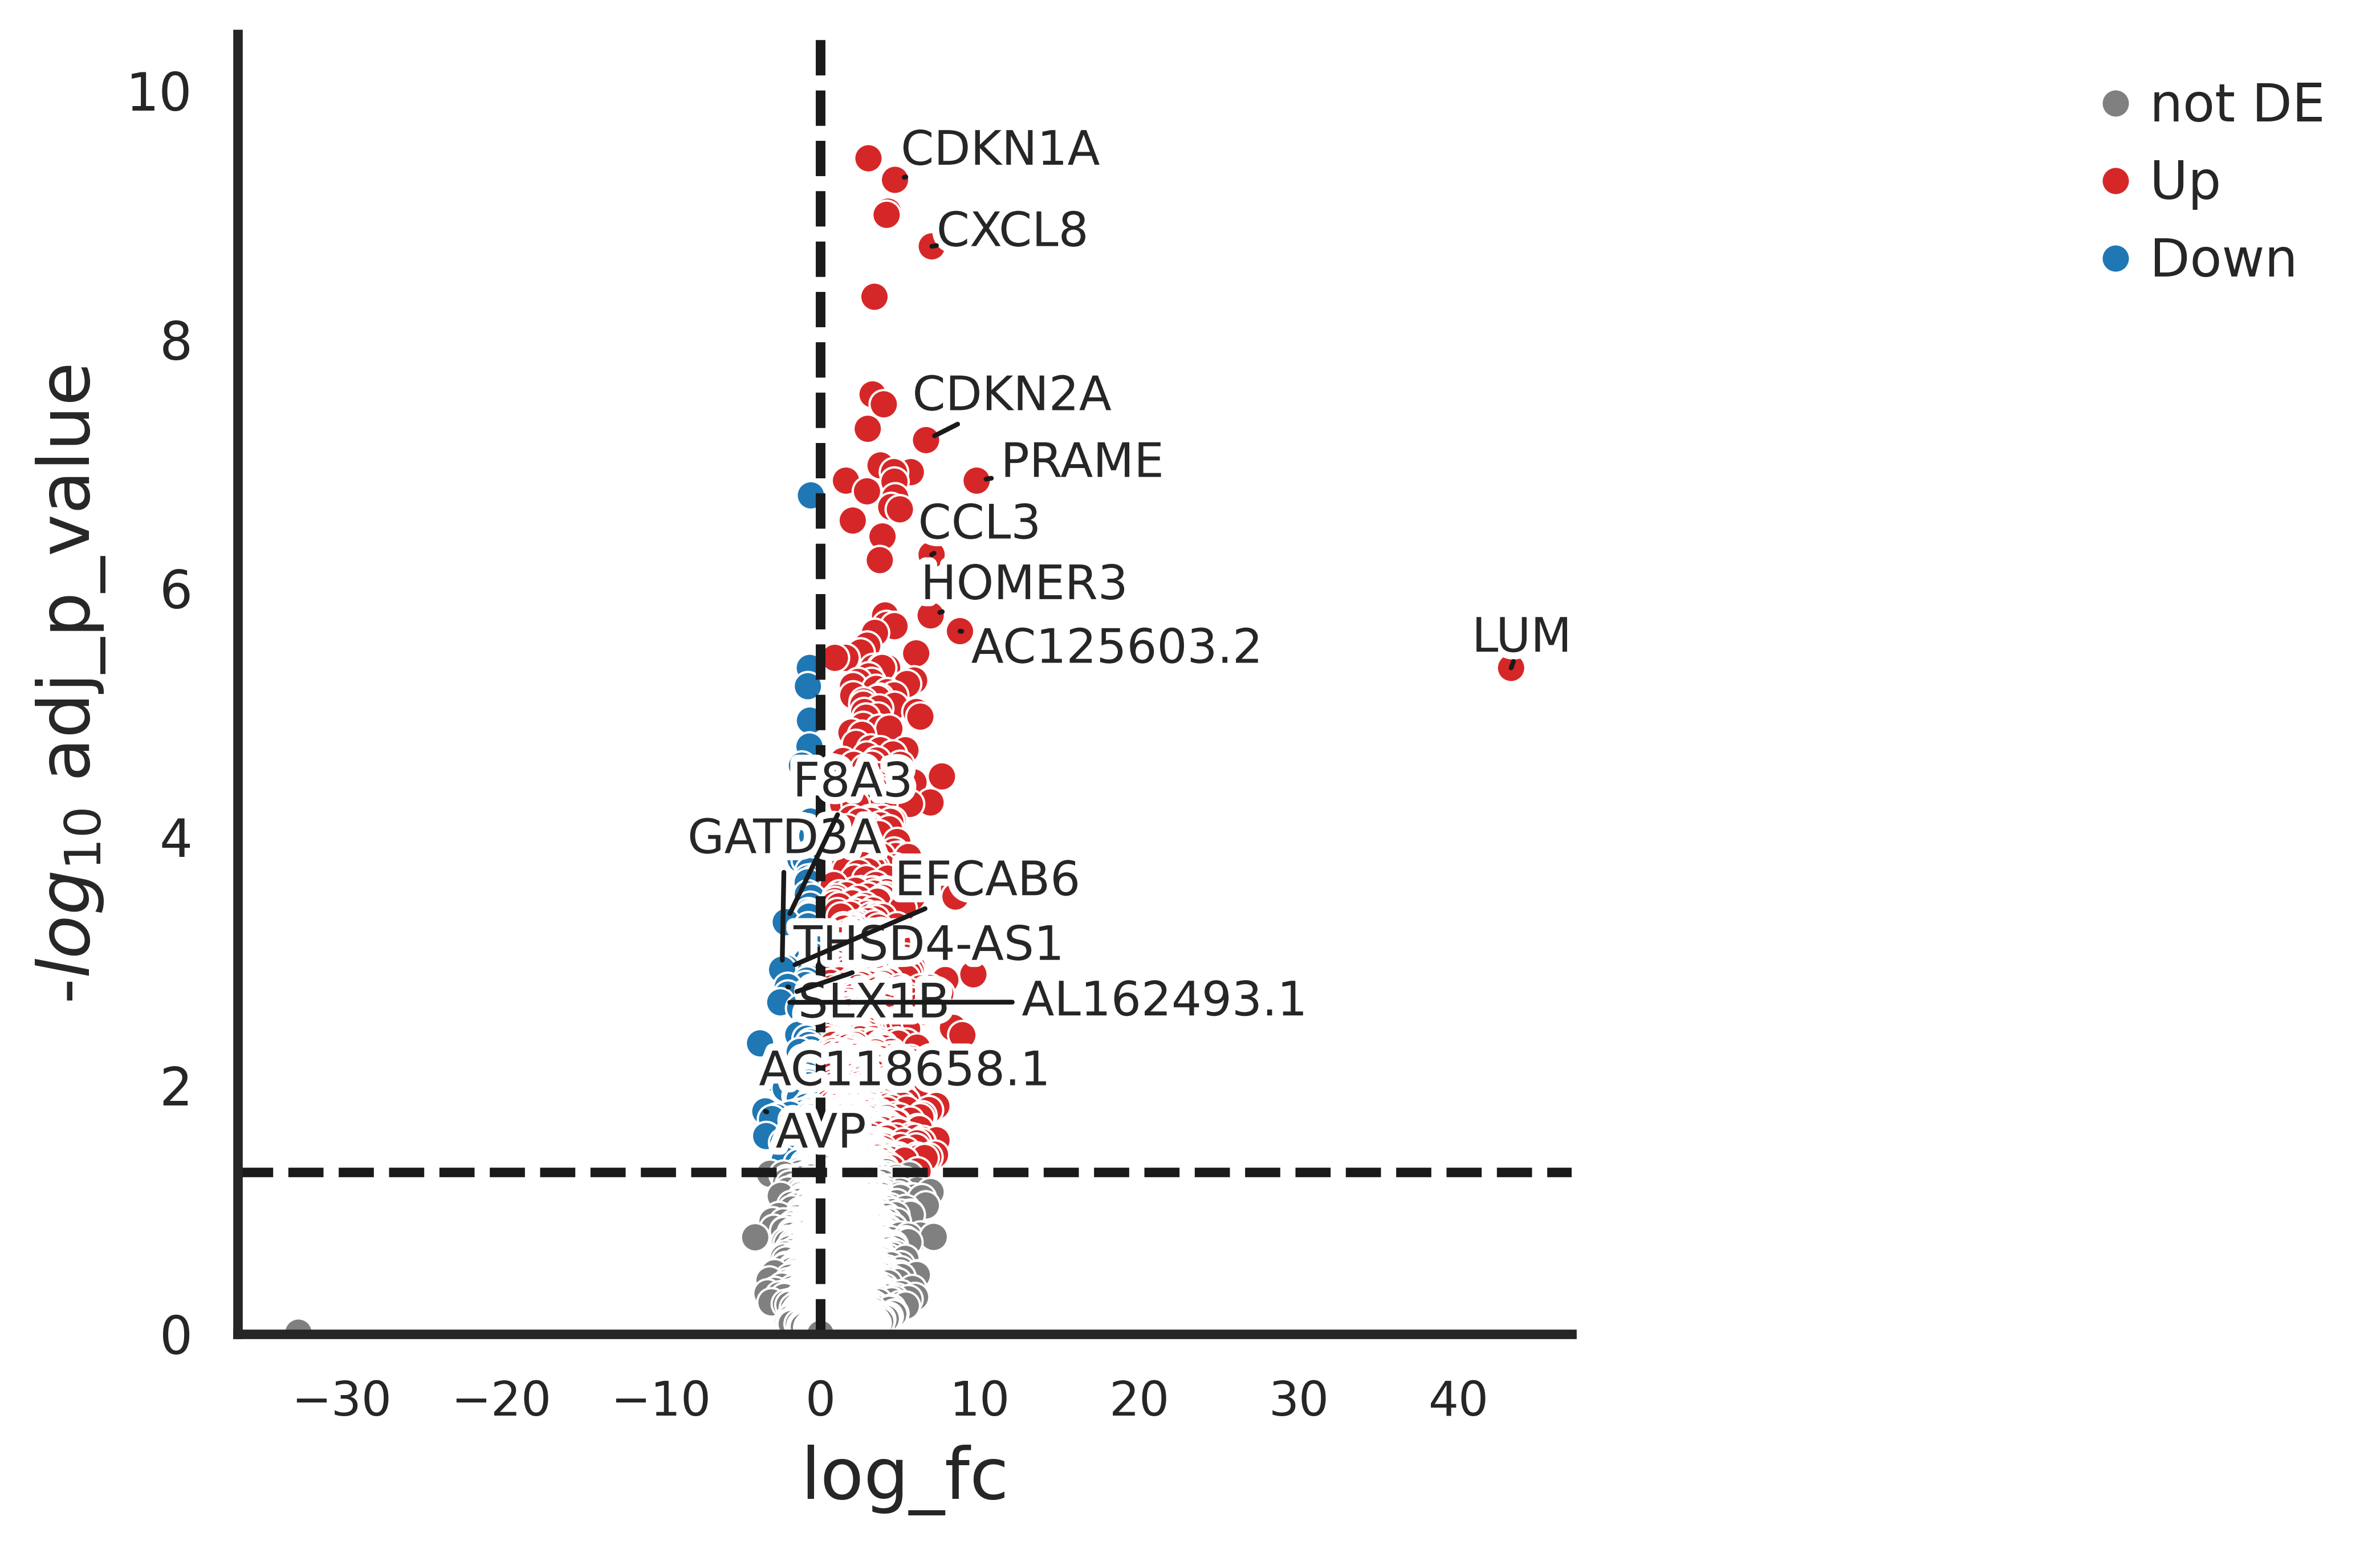

In [171]:
pds2.plot_volcano(res_df, log2fc_thresh=0, to_label = 8,save = True)

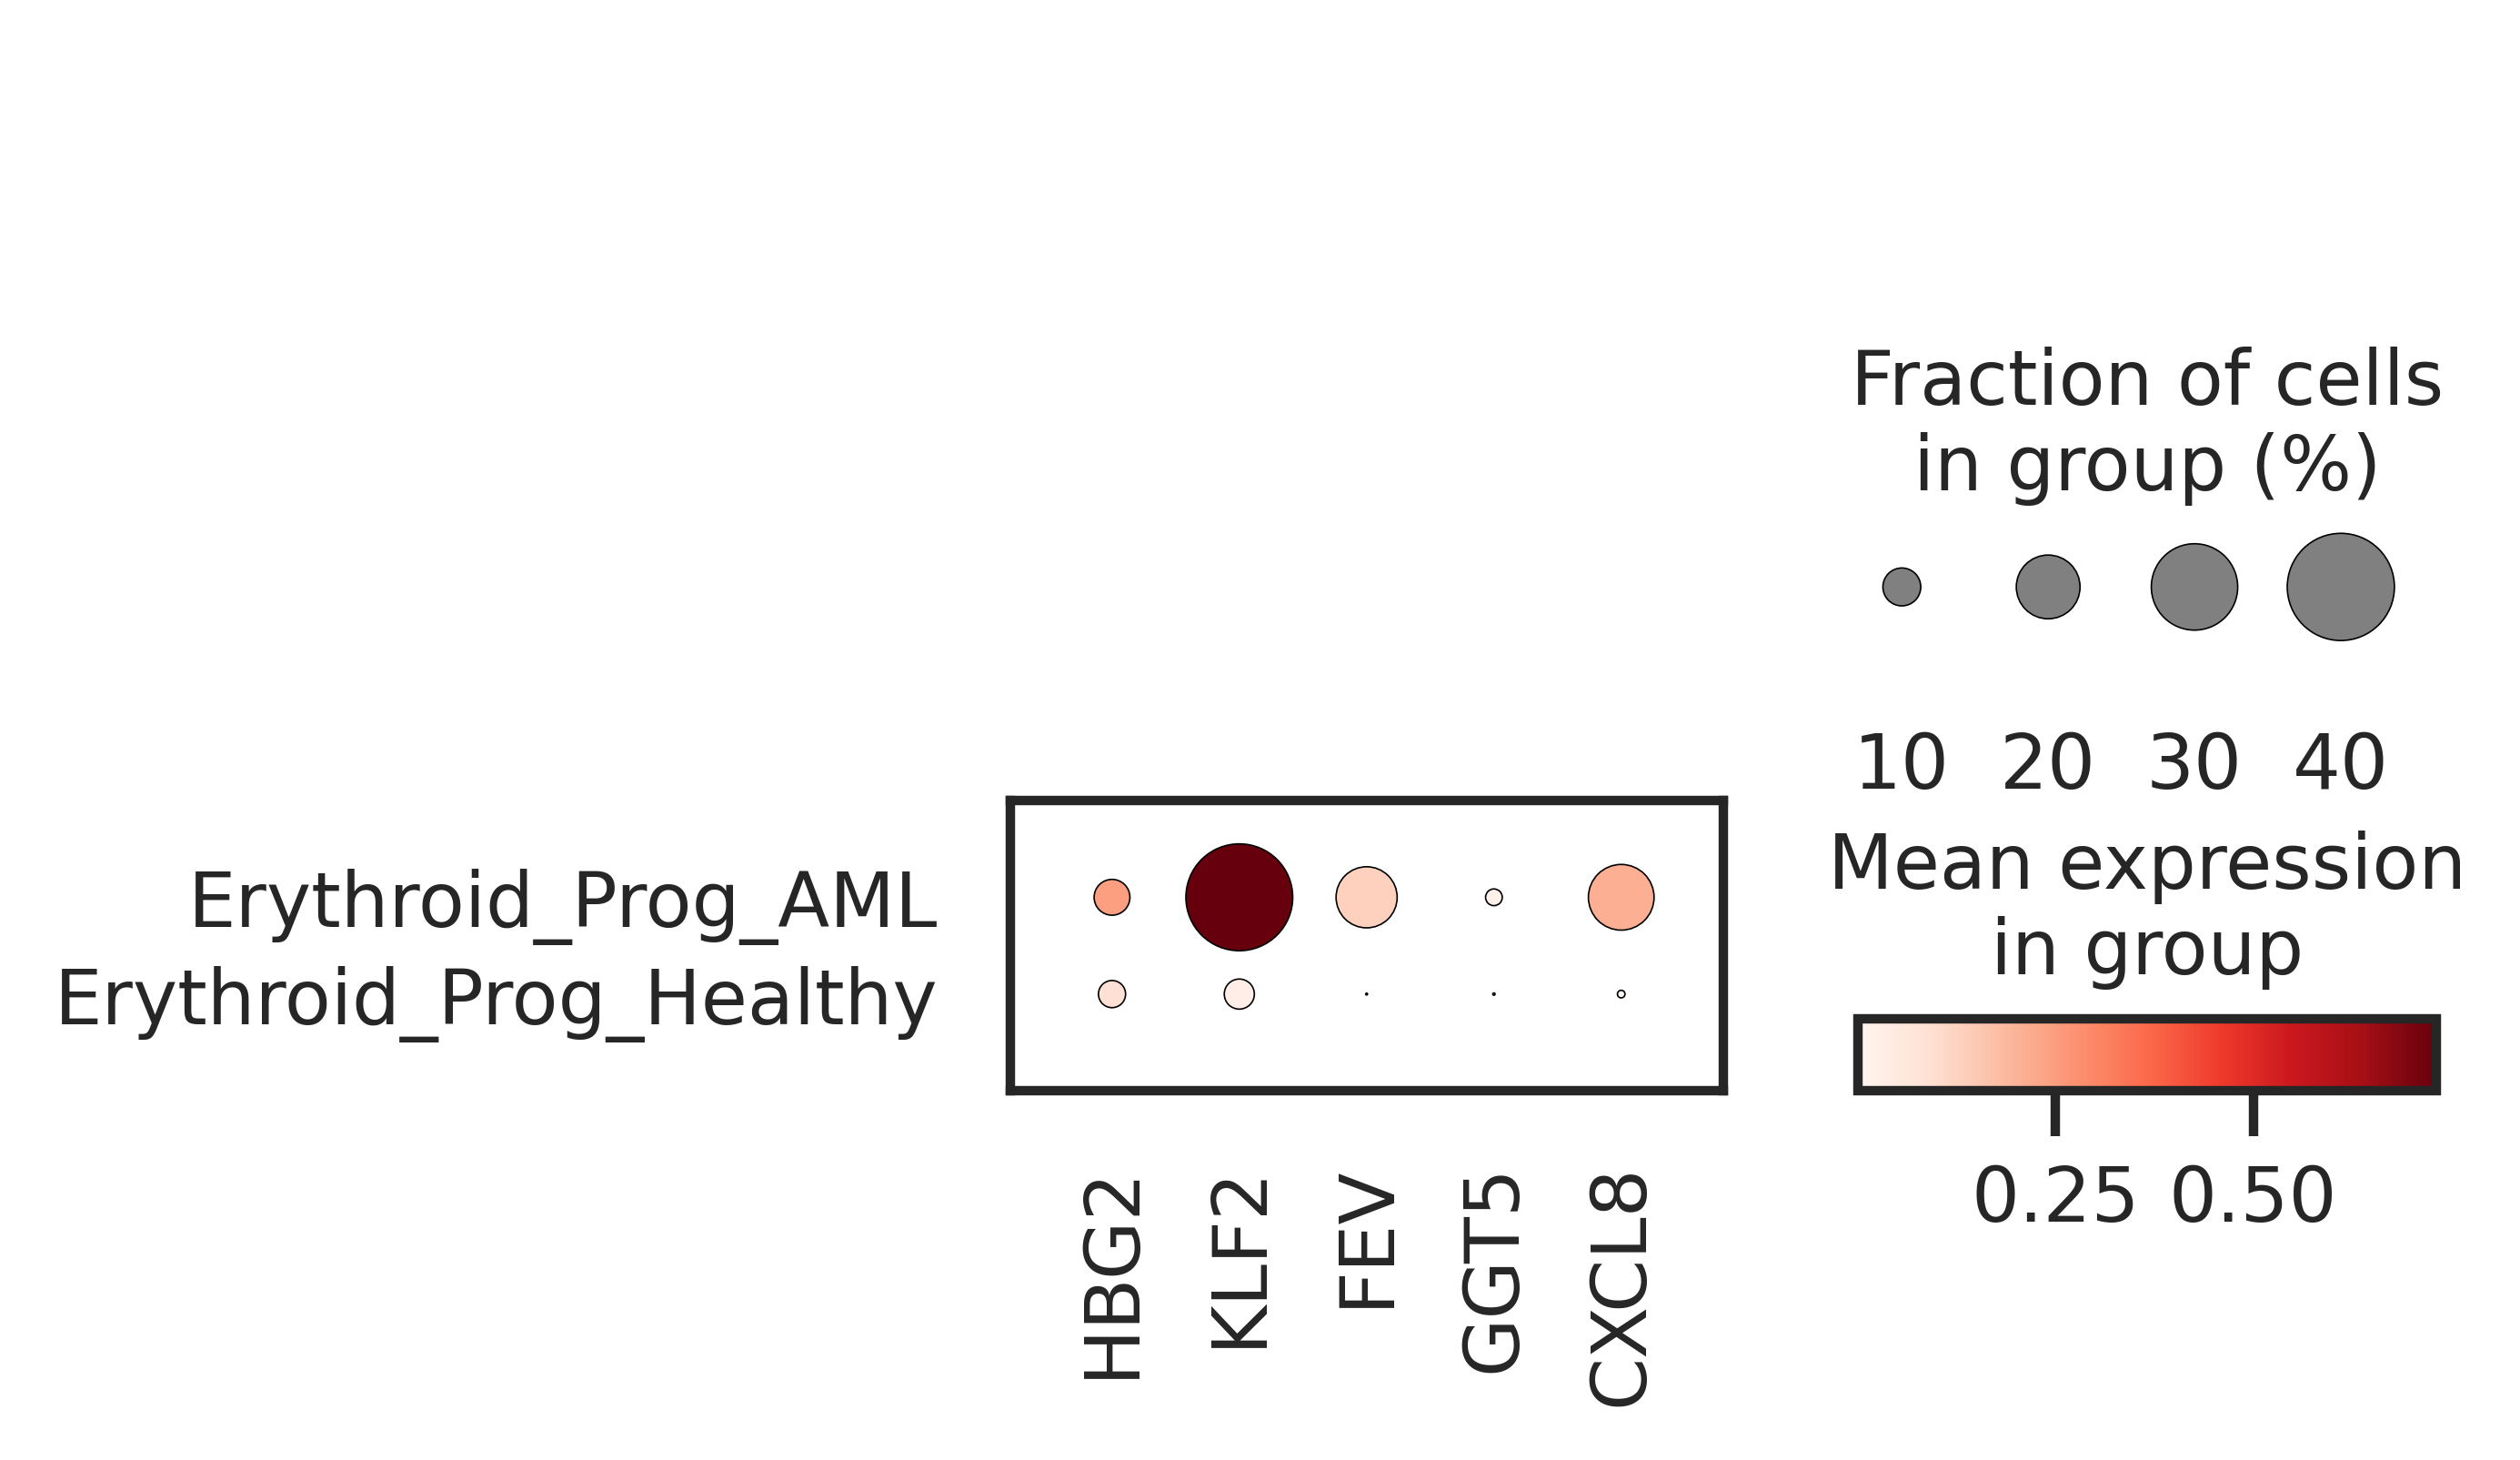

In [191]:
sc.pl.dotplot(MEP_MEP_like["rna"], var_names = ["HBG2","KLF2","FEV","GGT5","CXCL8"],
              groupby = "celltype_state")

In [41]:
categories_order = ["HSC_Healthy","GMP_Healthy","Erythroid_Prog_Healthy","Progenitors_AML",
                    "GMP_AML","Erythroid_Prog_AML"]

/home/sina.kanannejad/miniconda3/envs/pertpy-env/lib/python3.11/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/sina.kanannejad/miniconda3/envs/pertpy-env/lib/python3.11/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/sina.kanannejad/miniconda3/envs/pertpy-env/lib/python3.11/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/sina.kanannejad/miniconda3/envs/pertpy-env/lib/python3.11/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


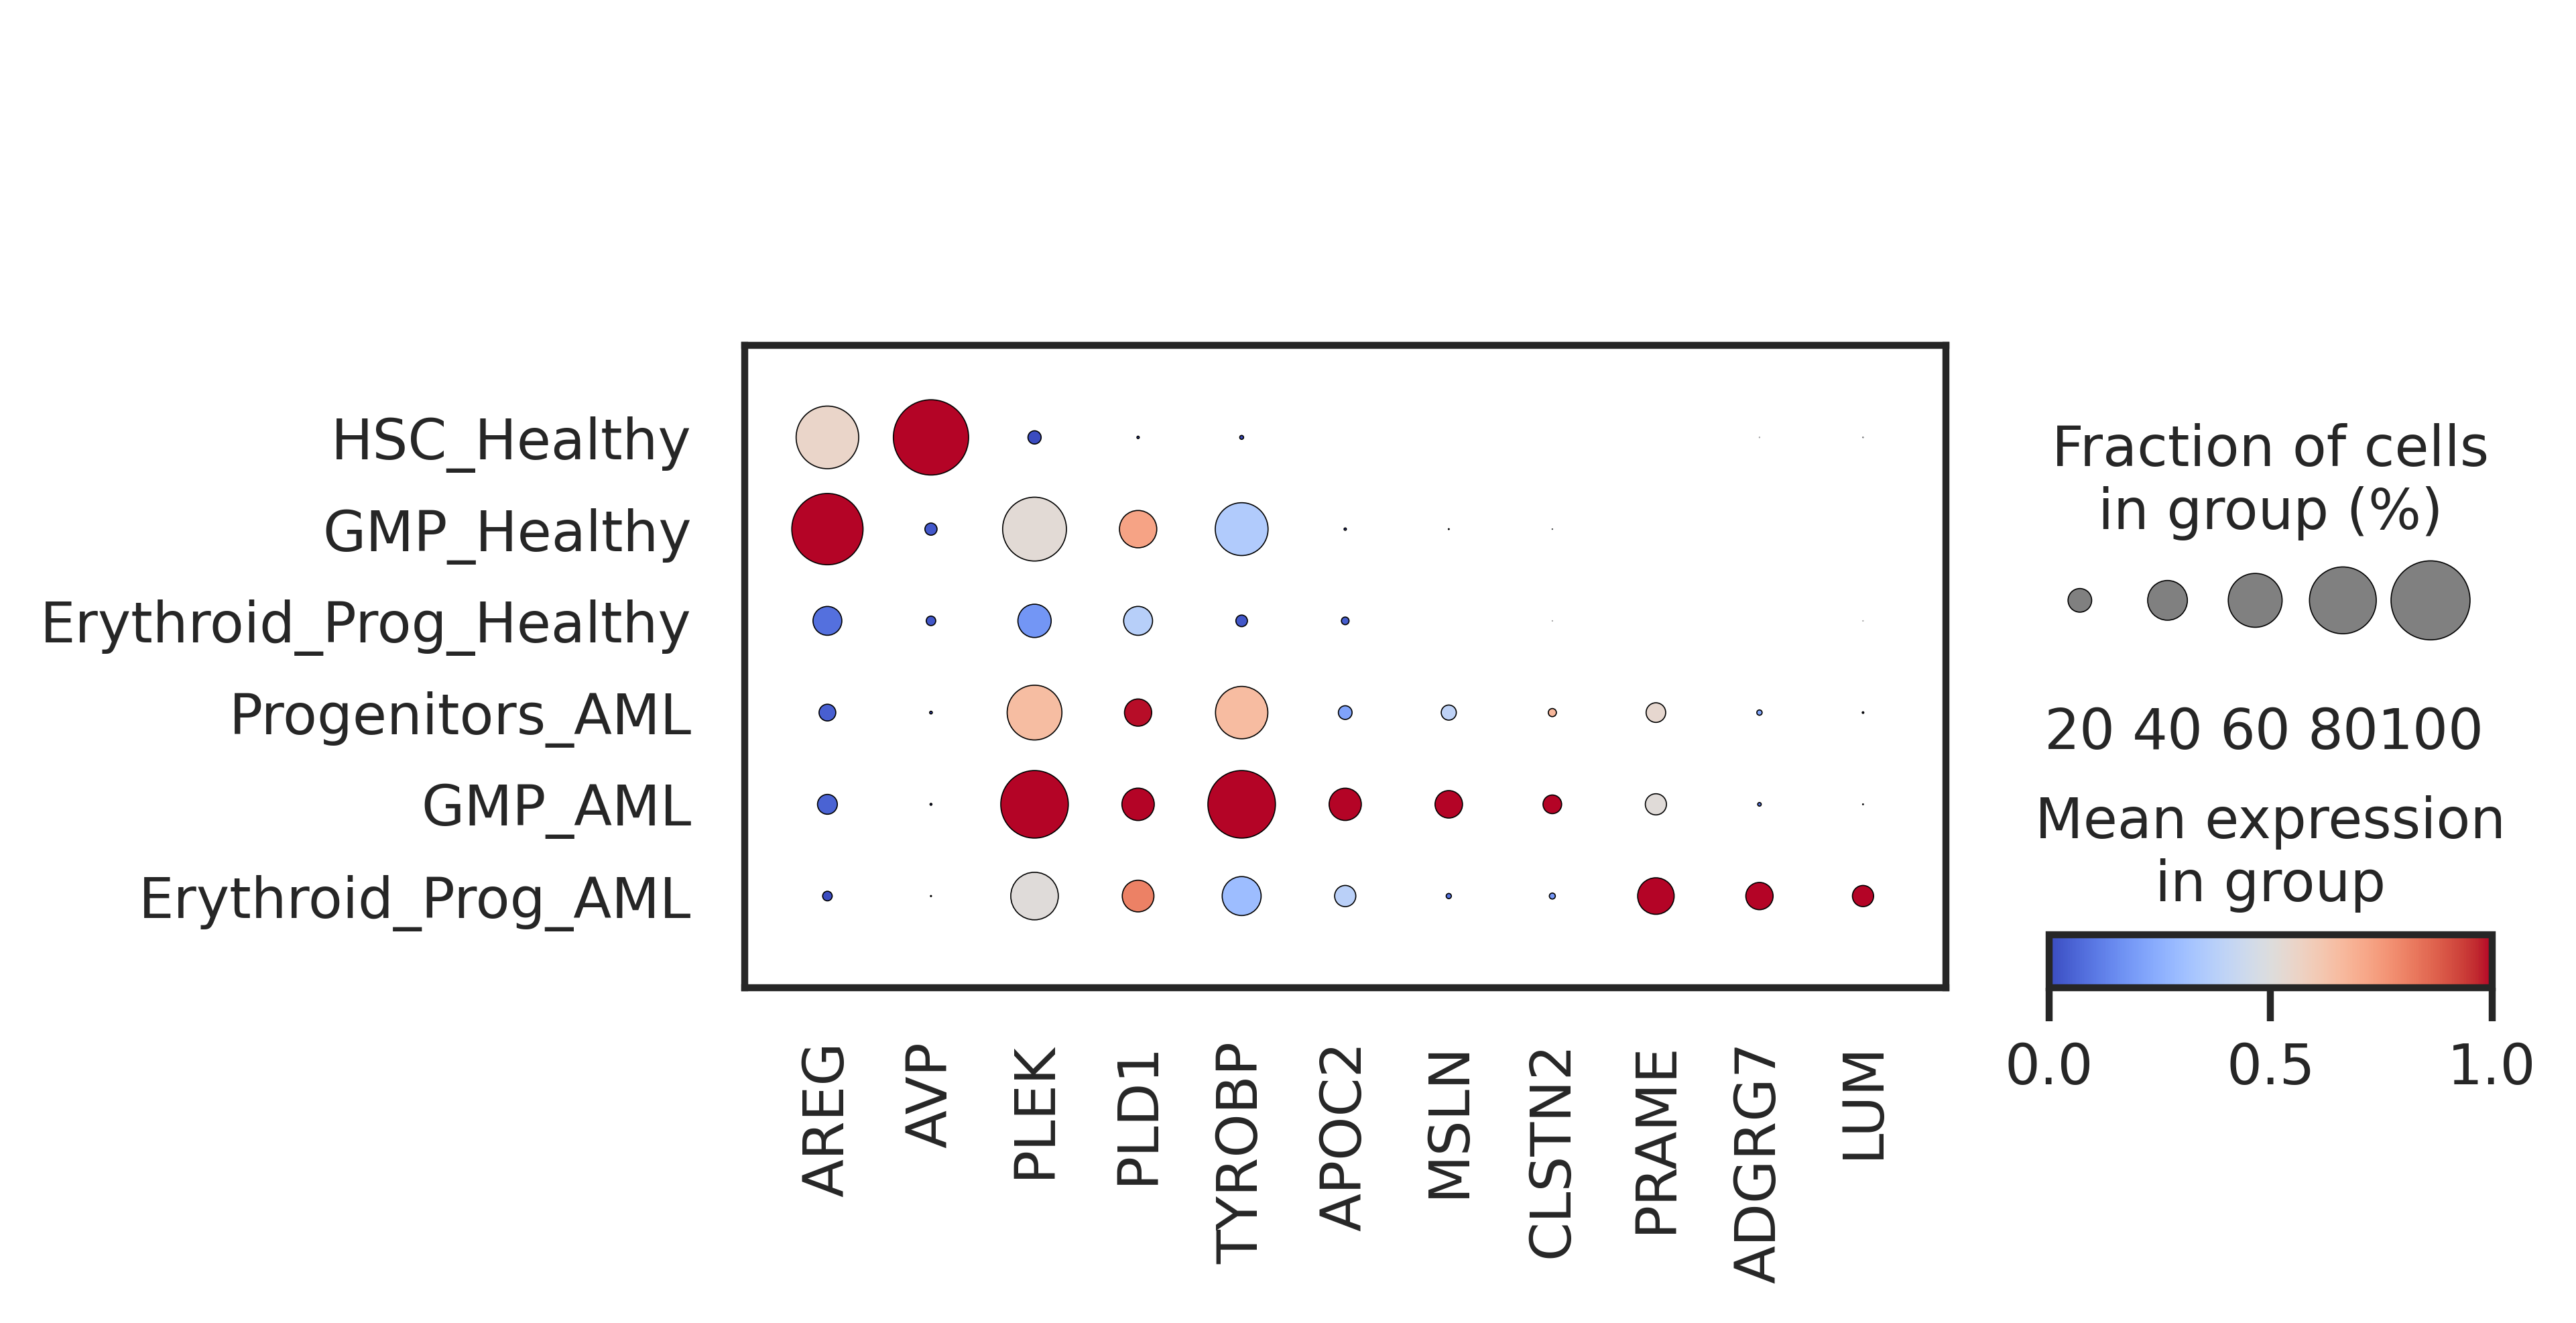

In [42]:
sc.pl.dotplot(AML_all["rna"][AML_all["rna"].obs["celltype_state"].isin(["GMP_Healthy","GMP_AML","HSC_Healthy","Progenitors_AML","Erythroid_Prog_Healthy","Erythroid_Prog_AML"])], 
              var_names = ["AREG","AVP","PLEK","PLD1","TYROBP","APOC2","MSLN","CLSTN2","PRAME"
                           ,"ADGRG7","LUM"],
              groupby = "celltype_state",standard_scale = "var",
              cmap = "coolwarm", categories_order = categories_order)

In [38]:
AML_all["rna"].obs["celltype_state"] = AML_all["rna"].obs["mapped_healthy"].astype(str) + "_" + AML_all["rna"].obs["state_major"].astype(str)
AML_all["rna"].obs["celltype_mal_norm"] = AML_all["rna"].obs["mapped_healthy"].astype(str) + "_" + AML_all["rna"].obs["malignancy_status"].astype(str) + "_" + AML_all["rna"].obs["state_major"].astype(str)


In [39]:
AML_all["rna"].obs[AML_all["rna"].obs["celltype_mal_norm"].isin(["HSC_normal_AML"])]["sample"].value_counts()>20

sample
AML15_Dx       True
AML19_Dx       True
AML10_Rel      True
AML8           True
AML9_Dx        True
AML6           True
AML10_Dx       True
AML19_Rel     False
AML13_Dx      False
AML9_Rel      False
AML17_Rel     False
AML14_Dx      False
AML12_Dx      False
AML12_Rel     False
AML7          False
AML14_Rel     False
AML11_Rel     False
AML13_Rel     False
AML3          False
AML11_Dx      False
AML12_Post    False
AML5          False
AML4          False
AML16_Rel     False
AML15_Rel     False
AML13_Post    False
CB1           False
CB2           False
HD1           False
HD2           False
PBM           False
Name: count, dtype: bool

/home/sina.kanannejad/miniconda3/envs/pertpy-env/lib/python3.11/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/sina.kanannejad/miniconda3/envs/pertpy-env/lib/python3.11/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/sina.kanannejad/miniconda3/envs/pertpy-env/lib/python3.11/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/sina.kanannejad/miniconda3/envs/pertpy-env/lib/python3.11/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


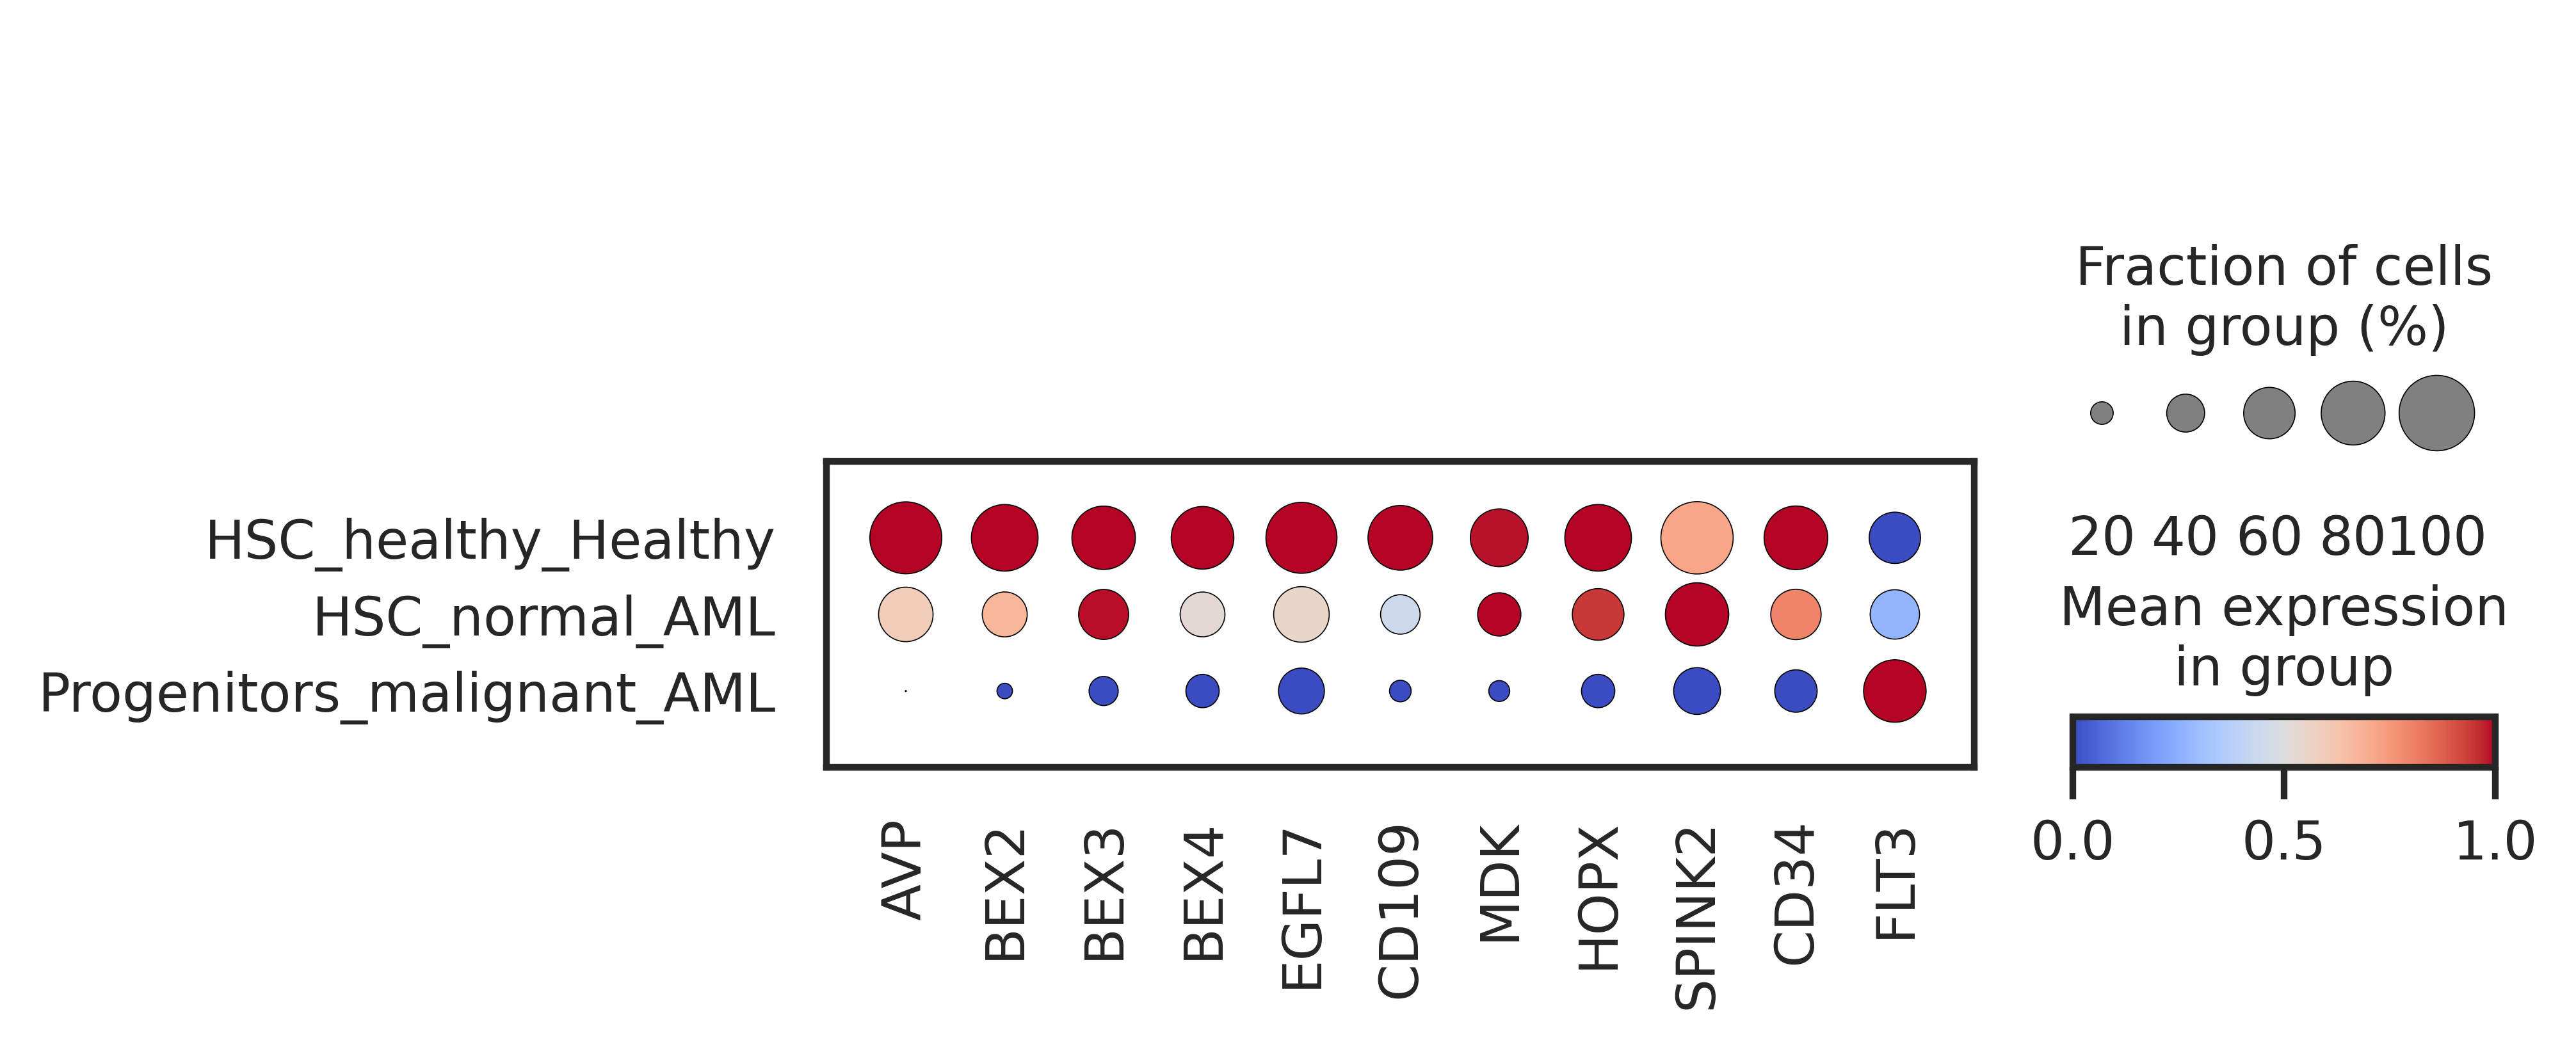

In [40]:
sc.pl.dotplot(AML_all["rna"][(AML_all["rna"].obs["sample"].isin(["AML15_Dx","AML19_Dx","AML10_Rel","AML8","AML9_Dx","AML10_Dx","PBM","HD1","HD2"])) & 
               (AML_all["rna"].obs["celltype_mal_norm"].isin(["HSC_healthy_Healthy", "Progenitors_malignant_AML", "HSC_normal_AML"]))], 
               groupby = "celltype_mal_norm", var_names = ["AVP","BEX2","BEX3","BEX4","EGFL7","CD109","MDK","HOPX","SPINK2","CD34","FLT3"], cmap = "coolwarm", standard_scale = "var", save = "Healhy_HSC_markers.pdf")